* All testing done in Google Colab using an A100.
* All package versions work together as of October 1st 2024.

In [1]:
!pip install transformers datasets accelerate bitsandbytes tabulate -q
!pip uninstall -y torch pyarrow
!pip install torch==2.4.0 pyarrow==14.0.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
Found existing installation: torch 2.4.1+cu121
Uninstalling torch-2.4.1+cu121:
  Successfully uninstalled torch-2.4.1+cu121
Found existing installation: pyarrow 16.1.0
Uninstalling pyarrow-16.1.0:
  Successfully uninstalled pyarrow-16.1.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Setup and imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from typing import List
from datasets import load_dataset
import json
import random

# set the model name
model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

# hugging face access token - make sure you have requested and have been granted permission to use meta-llama/Meta-Llama-3-8B-Instruct on hugging face
access_token = "<enter_your_huggingface_access_token_here>"

# set the font for all visualizations to Times New Roman
plt.rcParams['font.family'] = 'Liberation Serif'



# Figures 6 and 7

Loading model...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model loaded successfully
Model device: cuda:0
Analyzing how correlation varies across layers...
Processing prompt: Stefan goes to a restaurant to eat dinner with his...
Processing prompt: The gauge on a water tank shows that the tank is 1...
Processing prompt: Ben has 8 apples more than Phillip does. Tom has t...
Processing prompt: John wants to start a zoo.  He has 15 snakes.  He ...
Processing prompt: A portable battery charger can fully charge a smar...
Processing prompt: Darla needs to pay $4/watt of electricity for 300 ...
Processing prompt: There have been 15 "Where's Waldo?" books publishe...
Processing prompt: Bart makes a mixtape.  The first side has 6 songs....
Processing prompt: An old pirate wants to leave his treasure on an is...
Processing prompt: New York recorded 5000 new coronavirus cases on a ...
Processing prompt: Brady will make $450 more in a year than Dwayne. I...
Processing prompt: Carolyn is planning out her final essay. The intro...
Processing prompt: Marie ha

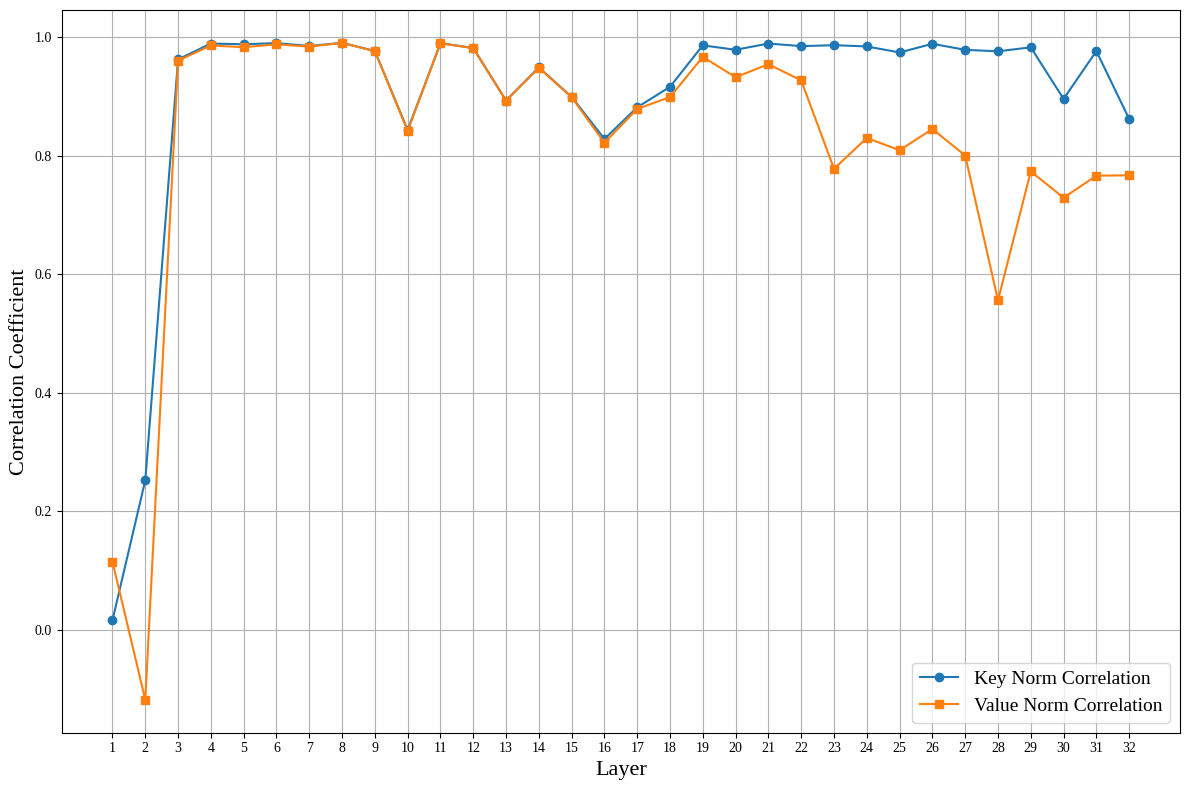

Plotting average correlation vs. grouping factor...
Analyzing grouping factor: 1
Analyzing grouping factor: 2
Analyzing grouping factor: 4
Analyzing grouping factor: 8
Plotting average correlation vs. grouping factor...


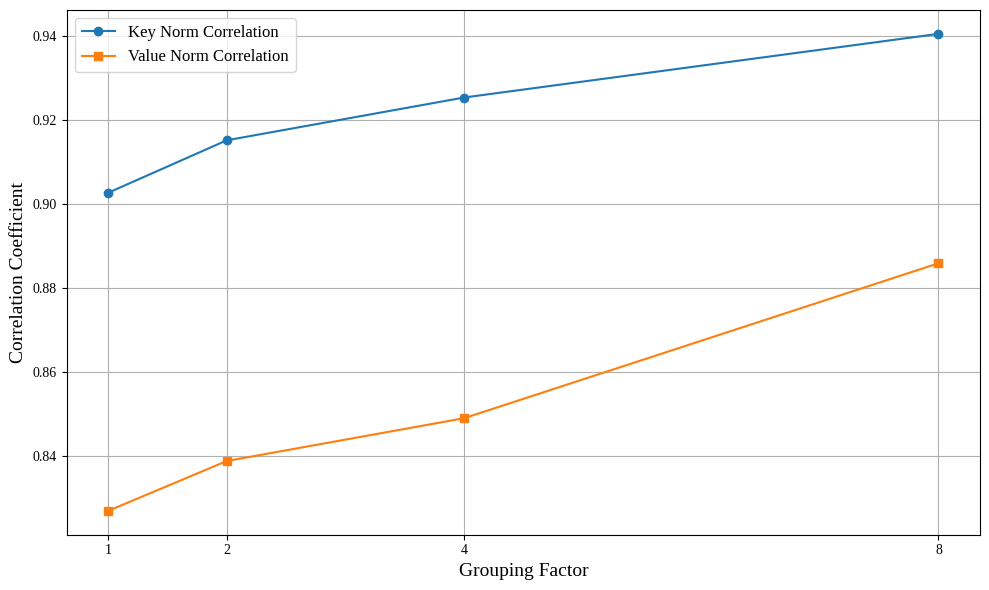

Plotting histograms of correlation coefficients...
Plotting histograms of correlation coefficients...


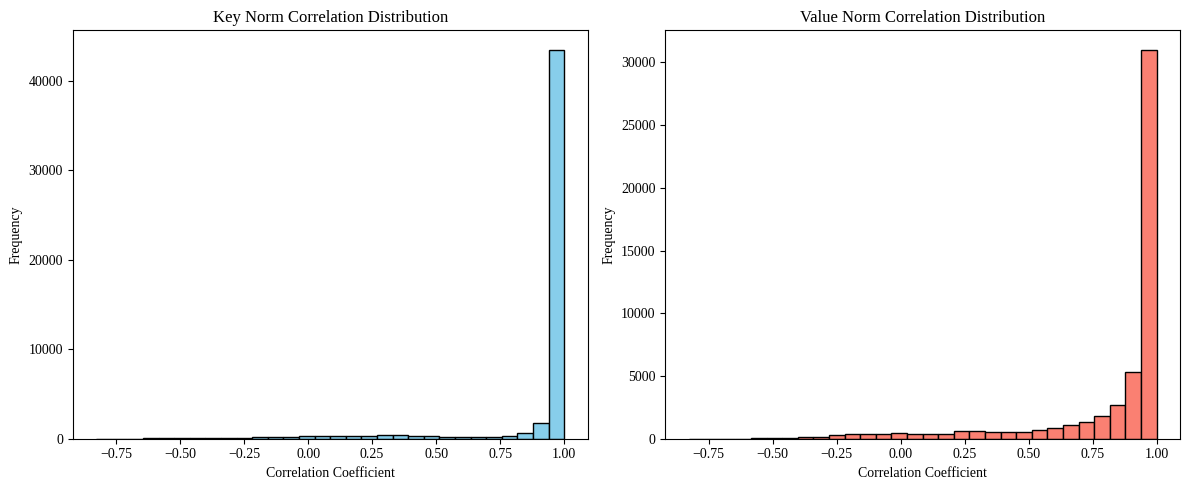

In [4]:
# main class - attention correlation analyzer
class AttentionCorrelationAnalyzer:
    def __init__(self, model_name: str, use_4bit: bool = True, access_token: str = None):
        """
        initialize the analyzer with a specified model and quantization options.

        args:
            model_name (str): name of the model to load.
            use_4bit (bool): whether to use 4-bit quantization.
            access_token (str): hugging face access token for private models.
        """
        # load the tokenizer for the specified model
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name,
            use_fast=True,
            token=access_token,
        )

        print("Loading model...")
        if use_4bit:
            # configure 4-bit quantization settings
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.float16,  # set compute dtype to float16 to match input type
            )
            # load the model with 4-bit quantization
            self.model = AutoModelForCausalLM.from_pretrained(
                model_name,
                device_map="auto",
                quantization_config=quantization_config,
                torch_dtype=torch.float16,
                low_cpu_mem_usage=True,
                token=access_token,
            )
        else:
            # load the model without quantization
            self.model = AutoModelForCausalLM.from_pretrained(
                model_name,
                device_map="auto",
                torch_dtype=torch.float16,
                low_cpu_mem_usage=True,
                token=access_token,
            )

        print("Model loaded successfully")
        # set the model to evaluation mode
        self.model.eval()
        # get the device where the model is loaded
        self.device = next(self.model.parameters()).device
        print(f"Model device: {self.device}")

        # store model configuration parameters
        self.config = self.model.config
        self.num_layers = self.config.num_hidden_layers  # number of transformer layers
        self.num_heads = self.config.num_attention_heads  # total number of attention heads
        self.hidden_size = self.config.hidden_size  # hidden size of the model
        self.head_dim = self.hidden_size // self.num_heads  # dimension per head
        # number of key/value heads (can be less than num_heads in grouped query attention)
        self.num_key_value_heads = getattr(self.config, 'num_key_value_heads', self.num_heads)
        self.head_dim_kv = self.head_dim  # dimension per key/value head
        # number of times key/value heads are repeated to match query heads
        self.n_rep = self.num_heads // self.num_key_value_heads

        # list to store the captured data from hooks
        self.kv_captures = []

        # register hooks to capture key/value vectors and attention scores
        self._register_hooks()

    def _register_hooks(self):
        """
        register forward hooks to capture key/value vectors and attention scores.
        """
        def create_hook(layer_idx):
            def hook(module, input, output):
                # extract hidden states from the input to the layer
                hidden_states = input[0]  # shape: [batch_size, seq_len, hidden_size]
                batch_size, seq_len, _ = hidden_states.size()

                # compute query, key, and value projections
                query_states = module.self_attn.q_proj(hidden_states)
                key_states = module.self_attn.k_proj(hidden_states)
                value_states = module.self_attn.v_proj(hidden_states)

                # reshape projections to separate heads
                # corrected reshaping to ensure proper dimensions
                query_states = query_states.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
                key_states = key_states.view(batch_size, seq_len, self.num_key_value_heads, self.head_dim_kv).transpose(1, 2)
                value_states = value_states.view(batch_size, seq_len, self.num_key_value_heads, self.head_dim_kv).transpose(1, 2)

                # repeat key and value states to match the number of query heads
                key_states = key_states.repeat_interleave(self.n_rep, dim=1)
                value_states = value_states.repeat_interleave(self.n_rep, dim=1)

                # scale query states by sqrt(head_dim)
                query_states = query_states / (self.head_dim ** 0.5)

                # compute attention scores
                attn_scores = torch.matmul(query_states, key_states.transpose(-1, -2))
                # apply softmax to get attention probabilities
                attn_probs = torch.nn.functional.softmax(attn_scores, dim=-1)

                # compute l2 norms of key and value vectors
                key_norms = torch.norm(key_states, dim=-1)
                value_norms = torch.norm(value_states, dim=-1)

                # store the captured data
                self.kv_captures.append({
                    'layer': layer_idx,
                    'attn_probs': attn_probs.detach().cpu(),
                    'key_norms': key_norms.detach().cpu(),
                    'value_norms': value_norms.detach().cpu(),
                })

            return hook

        # register the hook function for each transformer layer
        for idx, layer in enumerate(self.model.model.layers):
            layer.register_forward_hook(create_hook(idx))

    def analyze_prompts(self, prompts: List[str], max_prompts: int = None):
        """
        analyze a list of prompts to compute and visualize the correlation between l2 norms and attention scores.

        args:
            prompts (List[str]): list of prompts to analyze.
            max_prompts (int): maximum number of prompts to process.
        """
        if max_prompts:
            prompts = prompts[:max_prompts]

        for prompt in prompts:
            print(f"Processing prompt: {prompt[:50]}...")

            # reset captures for each prompt
            self.kv_captures = []

            # tokenize the prompt
            inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)

            # perform a forward pass through the model
            with torch.no_grad():
                outputs = self.model(**inputs)

            # analyze the captured data to compute and visualize correlations
            self._compute_and_visualize_correlations(inputs, prompt)

    def _compute_and_visualize_correlations(self, inputs, prompt):
        """
        compute the correlations and generate visualizations.

        args:
            inputs: the tokenized inputs.
            prompt (str): the original prompt text.
        """
        seq_len = inputs.input_ids.size(1)
        num_layers = self.num_layers
        num_heads = self.num_heads  # total number of attention heads

        # initialize matrices to store correlations for each layer and head
        key_correlations = np.zeros((num_layers, num_heads))
        value_correlations = np.zeros((num_layers, num_heads))

        # iterate over captured data from each layer
        for capture in self.kv_captures:
            layer_idx = capture['layer']
            attn_probs = capture['attn_probs'][0]  # shape: [num_heads, seq_len, seq_len]
            key_norms = capture['key_norms'][0]    # shape: [num_heads, seq_len]
            value_norms = capture['value_norms'][0]  # shape: [num_heads, seq_len]

            for head_idx in range(num_heads):
                # get attention probabilities for this head
                attn_head = attn_probs[head_idx]

                # get key and value norms for this head
                key_norm_head = key_norms[head_idx]
                value_norm_head = value_norms[head_idx]

                # flatten the attention scores and corresponding key/value norms
                attn_scores_flat = attn_head.flatten().numpy().astype(np.float64)
                key_norms_expanded = np.tile(key_norm_head.numpy(), (seq_len, 1)).astype(np.float64)
                value_norms_expanded = np.tile(value_norm_head.numpy(), (seq_len, 1)).astype(np.float64)

                key_norms_flat = key_norms_expanded.flatten()
                value_norms_flat = value_norms_expanded.flatten()

                # compute pearson correlation coefficients between attention scores and key norms
                if np.isfinite(attn_scores_flat).all() and np.isfinite(key_norms_flat).all():
                    if np.std(attn_scores_flat) > 0 and np.std(key_norms_flat) > 0:
                        key_corr = np.corrcoef(attn_scores_flat, key_norms_flat)[0, 1]
                    else:
                        key_corr = np.nan
                else:
                    key_corr = np.nan

                # compute pearson correlation coefficients between attention scores and value norms
                if np.isfinite(attn_scores_flat).all() and np.isfinite(value_norms_flat).all():
                    if np.std(attn_scores_flat) > 0 and np.std(value_norms_flat) > 0:
                        value_corr = np.corrcoef(attn_scores_flat, value_norms_flat)[0, 1]
                    else:
                        value_corr = np.nan
                else:
                    value_corr = np.nan

                # store the correlations
                key_correlations[layer_idx, head_idx] = key_corr
                value_correlations[layer_idx, head_idx] = value_corr

        # print context before generating the figure
        print("Generating heatmaps for the correlations between L2 norms and attention scores...")
        # generate heatmaps for the correlations
        self._visualize_correlations(key_correlations, value_correlations, level='Head', prompt=prompt)

    def _visualize_correlations(self, key_correlations, value_correlations, level='Head', prompt=''):
        """
        visualize the correlations as heatmaps.

        args:
            key_correlations: numpy array of shape [num_layers, num_heads].
            value_correlations: numpy array of shape [num_layers, num_heads].
            level: 'Head' or 'Grouped Heads'.
            prompt (str): the original prompt text for titling purposes.
        """
        layers = np.arange(1, self.num_layers + 1)
        num_units = key_correlations.shape[1]
        units = np.arange(1, num_units + 1)

        # create a grid for plotting
        fig, axs = plt.subplots(1, 2, figsize=(30, 20))
        fig.suptitle(f"Correlation between L2 Norms and Attention Scores at {level} Level\nPrompt: {prompt[:50]}...", fontsize=24)

        # define a colormap that avoids very light colors
        cmap = sns.diverging_palette(220, 20, as_cmap=True)

        # format annotations without leading zero and two decimal places
        fmt = '.2f'

        # key correlations heatmap
        sns.heatmap(
            key_correlations,
            ax=axs[0],
            cmap=cmap,
            vmin=-1,
            vmax=1,
            xticklabels=units,
            yticklabels=layers,
            annot=True,
            fmt=fmt,
            annot_kws={"size": 10, "color": "black"},
            cbar_kws={'shrink': 0.5},
        )
        axs[0].set_title("Key Norm Correlations", fontsize=20)
        axs[0].set_xlabel(level, fontsize=16)
        axs[0].set_ylabel("Layer", fontsize=16)

        # value correlations heatmap
        sns.heatmap(
            value_correlations,
            ax=axs[1],
            cmap=cmap,
            vmin=-1,
            vmax=1,
            xticklabels=units,
            yticklabels=layers,
            annot=True,
            fmt=fmt,
            annot_kws={"size": 10, "color": "black"},
            cbar_kws={'shrink': 0.5},
        )
        axs[1].set_title("Value Norm Correlations", fontsize=20)
        axs[1].set_xlabel(level, fontsize=16)
        axs[1].set_ylabel("Layer", fontsize=16)

        plt.tight_layout()
        plt.show()

    def analyze_head_groupings(self, prompts: List[str], max_prompts: int = None):
        """
        analyze how the correlation changes with varying number of heads per group.

        args:
            prompts (List[str]): list of prompts to analyze.
            max_prompts (int): maximum number of prompts to process.
        """
        if max_prompts:
            prompts = prompts[:max_prompts]

        # define different grouping configurations
        grouping_factors = [1, 2, 4, 8]
        for factor in grouping_factors:
            print(f"\nAnalyzing with head grouping factor = {factor}")
            grouped_num_heads = self.num_heads // factor

            if grouped_num_heads < 1:
                print(f"Grouping factor {factor} too large for num_heads {self.num_heads}, skipping.")
                continue

            # process prompts
            for prompt in prompts:
                print(f"Processing prompt: {prompt[:50]}...")

                # reset captures
                self.kv_captures = []

                # tokenize prompt
                inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)

                # forward pass
                with torch.no_grad():
                    outputs = self.model(**inputs)

                # analyze the captures with head grouping
                self._compute_and_visualize_correlations_with_head_grouping(inputs, factor, prompt)

    def _compute_and_visualize_correlations_with_head_grouping(self, inputs, grouping_factor, prompt):
        """
        compute correlations with head grouping.

        args:
            inputs: the tokenized inputs.
            grouping_factor: the factor by which heads are grouped.
            prompt (str): the original prompt text.
        """
        seq_len = inputs.input_ids.size(1)
        num_layers = self.num_layers
        grouped_num_heads = self.num_heads // grouping_factor

        # initialize matrices to store correlations
        key_correlations = np.zeros((num_layers, grouped_num_heads))
        value_correlations = np.zeros((num_layers, grouped_num_heads))

        # iterate over captured data
        for capture in self.kv_captures:
            layer_idx = capture['layer']
            attn_probs = capture['attn_probs'][0]  # shape: [num_heads, seq_len, seq_len]
            key_norms = capture['key_norms'][0]    # shape: [num_heads, seq_len]
            value_norms = capture['value_norms'][0]  # shape: [num_heads, seq_len]

            try:
                # group heads
                attn_probs_grouped = attn_probs.view(grouped_num_heads, grouping_factor, seq_len, seq_len).mean(dim=1)
                key_norms_grouped = key_norms.view(grouped_num_heads, grouping_factor, seq_len).mean(dim=1)
                value_norms_grouped = value_norms.view(grouped_num_heads, grouping_factor, seq_len).mean(dim=1)
            except RuntimeError as e:
                print(f"Error in grouping at layer {layer_idx} with grouping factor {grouping_factor}: {e}")
                continue

            for head_idx in range(grouped_num_heads):
                # get attention scores and norms for the grouped head
                attn_head = attn_probs_grouped[head_idx]
                key_norm_head = key_norms_grouped[head_idx]
                value_norm_head = value_norms_grouped[head_idx]

                # flatten and compute correlations
                attn_scores_flat = attn_head.flatten().numpy().astype(np.float64)
                key_norms_expanded = np.tile(key_norm_head.numpy(), (seq_len, 1)).astype(np.float64)
                value_norms_expanded = np.tile(value_norm_head.numpy(), (seq_len, 1)).astype(np.float64)

                key_norms_flat = key_norms_expanded.flatten()
                value_norms_flat = value_norms_expanded.flatten()

                # compute correlations between attention scores and key norms
                if np.isfinite(attn_scores_flat).all() and np.isfinite(key_norms_flat).all():
                    if np.std(attn_scores_flat) > 0 and np.std(key_norms_flat) > 0:
                        key_corr = np.corrcoef(attn_scores_flat, key_norms_flat)[0, 1]
                    else:
                        key_corr = np.nan
                else:
                    key_corr = np.nan

                # compute correlations between attention scores and value norms
                if np.isfinite(attn_scores_flat).all() and np.isfinite(value_norms_flat).all():
                    if np.std(attn_scores_flat) > 0 and np.std(value_norms_flat) > 0:
                        value_corr = np.corrcoef(attn_scores_flat, value_norms_flat)[0, 1]
                    else:
                        value_corr = np.nan
                else:
                    value_corr = np.nan

                # store the correlations
                key_correlations[layer_idx, head_idx] = key_corr
                value_correlations[layer_idx, head_idx] = value_corr

        # print context before generating the figure
        print(f"Generating heatmaps with grouping factor {grouping_factor} for prompt: {prompt[:50]}...")
        # generate heatmaps
        self._visualize_correlations(key_correlations, value_correlations, level=f'Grouped Heads (Factor {grouping_factor})', prompt=prompt)

    def analyze_layers(self, prompts: List[str], max_prompts: int = None):
        """
        visualize how the correlation varies across layers.

        args:
            prompts (List[str]): list of prompts to analyze.
            max_prompts (int): maximum number of prompts to process.
        """
        if max_prompts:
            prompts = prompts[:max_prompts]

        # initialize lists to store average correlations per layer
        avg_key_correlations = []
        avg_value_correlations = []

        for prompt in prompts:
            print(f"Processing prompt: {prompt[:50]}...")

            # reset captures
            self.kv_captures = []

            # tokenize prompt
            inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)

            # forward pass
            with torch.no_grad():
                outputs = self.model(**inputs)

            # compute correlations
            seq_len = inputs.input_ids.size(1)
            num_layers = self.num_layers
            num_heads = self.num_heads

            key_correlations = np.zeros((num_layers, num_heads))
            value_correlations = np.zeros((num_layers, num_heads))

            for capture in self.kv_captures:
                layer_idx = capture['layer']
                attn_probs = capture['attn_probs'][0]  # shape: [num_heads, seq_len, seq_len]
                key_norms = capture['key_norms'][0]    # shape: [num_heads, seq_len]
                value_norms = capture['value_norms'][0]  # shape: [num_heads, seq_len]

                for head_idx in range(num_heads):
                    # get attention probabilities and norms for this head
                    attn_head = attn_probs[head_idx]
                    key_norm_head = key_norms[head_idx]
                    value_norm_head = value_norms[head_idx]

                    # flatten and compute correlations
                    attn_scores_flat = attn_head.flatten().numpy().astype(np.float64)
                    key_norms_expanded = np.tile(key_norm_head.numpy(), (seq_len, 1)).astype(np.float64)
                    value_norms_expanded = np.tile(value_norm_head.numpy(), (seq_len, 1)).astype(np.float64)

                    key_norms_flat = key_norms_expanded.flatten()
                    value_norms_flat = value_norms_expanded.flatten()

                    if np.isfinite(attn_scores_flat).all() and np.isfinite(key_norms_flat).all():
                        if np.std(attn_scores_flat) > 0 and np.std(key_norms_flat) > 0:
                            key_corr = np.corrcoef(attn_scores_flat, key_norms_flat)[0, 1]
                        else:
                            key_corr = np.nan
                    else:
                        key_corr = np.nan

                    if np.isfinite(attn_scores_flat).all() and np.isfinite(value_norms_flat).all():
                        if np.std(attn_scores_flat) > 0 and np.std(value_norms_flat) > 0:
                            value_corr = np.corrcoef(attn_scores_flat, value_norms_flat)[0, 1]
                        else:
                            value_corr = np.nan
                    else:
                        value_corr = np.nan

                    key_correlations[layer_idx, head_idx] = key_corr
                    value_correlations[layer_idx, head_idx] = value_corr

            # compute average correlations per layer
            avg_key_corr_per_layer = np.nanmean(key_correlations, axis=1)
            avg_value_corr_per_layer = np.nanmean(value_correlations, axis=1)

            avg_key_correlations.append(avg_key_corr_per_layer)
            avg_value_correlations.append(avg_value_corr_per_layer)

        # compute mean over prompts
        avg_key_correlations = np.nanmean(avg_key_correlations, axis=0)
        avg_value_correlations = np.nanmean(avg_value_correlations, axis=0)

        # print context before plotting
        print("Plotting average correlation across layers...")
        # plot the correlations across layers
        layers = np.arange(1, self.num_layers + 1)

        plt.figure(figsize=(12, 8))
        plt.plot(layers, avg_key_correlations, label='Key Norm Correlation', marker='o')
        plt.plot(layers, avg_value_correlations, label='Value Norm Correlation', marker='s')
        # plt.title('Average Correlation Across Layers', fontsize=20)
        plt.xlabel('Layer', fontsize=16)
        plt.ylabel('Correlation Coefficient', fontsize=16)
        plt.legend(fontsize=14)
        plt.grid(True)
        plt.xticks(layers)
        plt.tight_layout()
        plt.show()

    def plot_correlation_vs_grouping(self, prompts: List[str], max_prompts: int = None):
        """
        plot average correlation vs. grouping factor.

        args:
            prompts (List[str]): list of prompts to analyze.
            max_prompts (int): maximum number of prompts to process.
        """
        if max_prompts:
            prompts = prompts[:max_prompts]

        grouping_factors = [1, 2, 4, 8]
        avg_key_correlations = []
        avg_value_correlations = []
        valid_factors = []

        for factor in grouping_factors:
            grouped_num_heads = self.num_heads // factor
            if grouped_num_heads < 1:
                continue

            key_corrs = []
            value_corrs = []

            print(f"Analyzing grouping factor: {factor}")

            for prompt in prompts:
                self.kv_captures = []
                inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
                with torch.no_grad():
                    outputs = self.model(**inputs)

                seq_len = inputs.input_ids.size(1)
                num_layers = self.num_layers

                key_correlations = np.zeros((num_layers, grouped_num_heads))
                value_correlations = np.zeros((num_layers, grouped_num_heads))

                for capture in self.kv_captures:
                    layer_idx = capture['layer']
                    attn_probs = capture['attn_probs'][0]  # shape: [num_heads, seq_len, seq_len]
                    key_norms = capture['key_norms'][0]    # shape: [num_heads, seq_len]
                    value_norms = capture['value_norms'][0]  # shape: [num_heads, seq_len]

                    try:
                        # group heads
                        attn_probs_grouped = attn_probs.view(grouped_num_heads, factor, seq_len, seq_len).mean(dim=1)
                        key_norms_grouped = key_norms.view(grouped_num_heads, factor, seq_len).mean(dim=1)
                        value_norms_grouped = value_norms.view(grouped_num_heads, factor, seq_len).mean(dim=1)
                    except RuntimeError:
                        continue

                    for head_idx in range(grouped_num_heads):
                        attn_head = attn_probs_grouped[head_idx]
                        key_norm_head = key_norms_grouped[head_idx]
                        value_norm_head = value_norms_grouped[head_idx]

                        attn_scores_flat = attn_head.flatten().numpy().astype(np.float64)
                        key_norms_flat = np.tile(key_norm_head.numpy(), (seq_len, 1)).astype(np.float64).flatten()
                        value_norms_flat = np.tile(value_norm_head.numpy(), (seq_len, 1)).astype(np.float64).flatten()

                        if np.isfinite(attn_scores_flat).all() and np.isfinite(key_norms_flat).all():
                            if np.std(attn_scores_flat) > 0 and np.std(key_norms_flat) > 0:
                                key_corr = np.corrcoef(attn_scores_flat, key_norms_flat)[0, 1]
                            else:
                                key_corr = np.nan
                        else:
                            key_corr = np.nan

                        if np.isfinite(attn_scores_flat).all() and np.isfinite(value_norms_flat).all():
                            if np.std(attn_scores_flat) > 0 and np.std(value_norms_flat) > 0:
                                value_corr = np.corrcoef(attn_scores_flat, value_norms_flat)[0, 1]
                            else:
                                value_corr = np.nan
                        else:
                            value_corr = np.nan

                        key_correlations[layer_idx, head_idx] = key_corr
                        value_correlations[layer_idx, head_idx] = value_corr

                key_corrs.append(np.nanmean(key_correlations))
                value_corrs.append(np.nanmean(value_correlations))

            avg_key_correlations.append(np.nanmean(key_corrs))
            avg_value_correlations.append(np.nanmean(value_corrs))
            valid_factors.append(factor)

        # print context before plotting
        print("Plotting average correlation vs. grouping factor...")
        # plot the results
        plt.figure(figsize=(10, 6))
        plt.plot(valid_factors, avg_key_correlations, label='Key Norm Correlation', marker='o')
        plt.plot(valid_factors, avg_value_correlations, label='Value Norm Correlation', marker='s')
        # plt.title('Average Correlation vs. Grouping Factor', fontsize=16)
        plt.xlabel('Grouping Factor', fontsize=14)
        plt.ylabel('Correlation Coefficient', fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.xticks(valid_factors)
        plt.tight_layout()
        plt.show()

    def plot_correlation_histograms(self, prompts: List[str], max_prompts: int = None):
        """
        plot histograms of correlation coefficients.

        args:
            prompts (List[str]): list of prompts to analyze.
            max_prompts (int): maximum number of prompts to process.
        """
        if max_prompts:
            prompts = prompts[:max_prompts]

        all_key_correlations = []
        all_value_correlations = []

        for prompt in prompts:
            self.kv_captures = []
            inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
            with torch.no_grad():
                outputs = self.model(**inputs)

            seq_len = inputs.input_ids.size(1)
            num_layers = self.num_layers
            num_heads = self.num_heads

            key_correlations = np.zeros((num_layers, num_heads))
            value_correlations = np.zeros((num_layers, num_heads))

            for capture in self.kv_captures:
                layer_idx = capture['layer']
                attn_probs = capture['attn_probs'][0]
                key_norms = capture['key_norms'][0]
                value_norms = capture['value_norms'][0]

                for head_idx in range(num_heads):
                    attn_head = attn_probs[head_idx]
                    key_norm_head = key_norms[head_idx]
                    value_norm_head = value_norms[head_idx]

                    attn_scores_flat = attn_head.flatten().numpy().astype(np.float64)
                    key_norms_flat = np.tile(key_norm_head.numpy(), (seq_len, 1)).astype(np.float64).flatten()
                    value_norms_flat = np.tile(value_norm_head.numpy(), (seq_len, 1)).astype(np.float64).flatten()

                    if np.isfinite(attn_scores_flat).all() and np.isfinite(key_norms_flat).all():
                        if np.std(attn_scores_flat) > 0 and np.std(key_norms_flat) > 0:
                            key_corr = np.corrcoef(attn_scores_flat, key_norms_flat)[0, 1]
                        else:
                            key_corr = np.nan
                    else:
                        key_corr = np.nan

                    if np.isfinite(attn_scores_flat).all() and np.isfinite(value_norms_flat).all():
                        if np.std(attn_scores_flat) > 0 and np.std(value_norms_flat) > 0:
                            value_corr = np.corrcoef(attn_scores_flat, value_norms_flat)[0, 1]
                        else:
                            value_corr = np.nan
                    else:
                        value_corr = np.nan

                    key_correlations[layer_idx, head_idx] = key_corr
                    value_correlations[layer_idx, head_idx] = value_corr

            # collect all correlations
            all_key_correlations.extend(key_correlations.flatten())
            all_value_correlations.extend(value_correlations.flatten())

        # remove NaN values
        all_key_correlations = [corr for corr in all_key_correlations if not np.isnan(corr)]
        all_value_correlations = [corr for corr in all_value_correlations if not np.isnan(corr)]

        # print context before plotting
        print("Plotting histograms of correlation coefficients...")
        # plot histograms
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.hist(all_key_correlations, bins=30, color='skyblue', edgecolor='black')
        plt.title('Key Norm Correlation Distribution')
        plt.xlabel('Correlation Coefficient')
        plt.ylabel('Frequency')

        plt.subplot(1, 2, 2)
        plt.hist(all_value_correlations, bins=30, color='salmon', edgecolor='black')
        plt.title('Value Norm Correlation Distribution')
        plt.xlabel('Correlation Coefficient')
        plt.ylabel('Frequency')

        plt.tight_layout()
        plt.show()

# function to load K-QA prompts from JSONL data
def load_kqa_prompts(jsonl_data):
    """
    load k-qa prompts from a jsonl string.

    args:
        jsonl_data (str): multi-line string containing json-formatted data.

    returns:
        List[str]: list of questions extracted from the data.
    """
    prompts = []
    for line in jsonl_data.strip().split('\n'):
        data = json.loads(line)
        question = data.get('Question', '')
        if question:
            prompts.append(question)
    return prompts

# usage example
if __name__ == "__main__":
    model_name = "meta-llama/Meta-Llama-3-8B-Instruct"


    # clear cuda cache
    torch.cuda.empty_cache()

    # instantiate the analyzer
    analyzer = AttentionCorrelationAnalyzer(model_name, access_token=access_token)

    # load datasets
    # gsm8k dataset
    gsm8k_ds = load_dataset("openai/gsm8k", "main")
    gsm8k_prompts = [x['question'] for x in gsm8k_ds['train']]

    # k-qa dataset (assumed to be provided in full as '/content/questions.jsonl')
    # load k-qa prompts

    # combine prompts from both datasets
    all_prompts = gsm8k_prompts

    # randomly select prompts
    random.seed(42)  # for reproducibility
    random.shuffle(all_prompts)
    max_prompts = 50
    selected_prompts = all_prompts[:max_prompts]

    # analyze prompts (heatmaps for each prompt)
    # print("Analyzing prompts and generating heatmaps...")
    # analyzer.analyze_prompts(selected_prompts)

    # analyze head groupings including grouping factor 4 (default for llama-3)
    # process the selected prompts
    # print("Analyzing head groupings with varying grouping factors...")
    # analyzer.analyze_head_groupings(selected_prompts)

    # analyze how correlation varies across layers
    print("Analyzing how correlation varies across layers...")
    analyzer.analyze_layers(selected_prompts)

    # plot average correlation vs. grouping factor
    print("Plotting average correlation vs. grouping factor...")
    analyzer.plot_correlation_vs_grouping(selected_prompts)

    # plot histograms of correlation coefficients
    print("Plotting histograms of correlation coefficients...")
    analyzer.plot_correlation_histograms(selected_prompts)

    # clear cuda cache
    torch.cuda.empty_cache()


# Figure 8

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:786: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Loading model...


/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:469: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Model loaded successfully
Model device: cuda:0
Registered hook for layer 0
Registered hook for layer 1
Registered hook for layer 2
Registered hook for layer 3
Registered hook for layer 4
Registered hook for layer 5
Registered hook for layer 6
Registered hook for layer 7
Registered hook for layer 8
Registered hook for layer 9
Registered hook for layer 10
Registered hook for layer 11
Registered hook for layer 12
Registered hook for layer 13
Registered hook for layer 14
Registered hook for layer 15
Registered hook for layer 16
Registered hook for layer 17
Registered hook for layer 18
Registered hook for layer 19
Registered hook for layer 20
Registered hook for layer 21
Registered hook for layer 22
Registered hook for layer 23
Registered hook for layer 24
Registered hook for layer 25
Registered hook for layer 26
Registered hook for layer 27
Registered hook for layer 28
Registered hook for layer 29
Registered hook for layer 30
Registered hook for layer 31
Processing prompt: Hello, how are y

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Layer 0: num_heads=32, num_kv_heads=8
Layer 0 captured key_norms_before shape: torch.Size([1, 32, 17])
Layer 0 captured key_vectors shape: torch.Size([1, 32, 17, 128])
Layer 1: num_heads=32, num_kv_heads=8
Layer 1 captured key_norms_before shape: torch.Size([1, 32, 17])
Layer 1 captured key_vectors shape: torch.Size([1, 32, 17, 128])
Layer 2: num_heads=32, num_kv_heads=8
Layer 2 captured key_norms_before shape: torch.Size([1, 32, 17])
Layer 2 captured key_vectors shape: torch.Size([1, 32, 17, 128])
Layer 3: num_heads=32, num_kv_heads=8
Layer 3 captured key_norms_before shape: torch.Size([1, 32, 17])
Layer 3 captured key_vectors shape: torch.Size([1, 32, 17, 128])
Layer 4: num_heads=32, num_kv_heads=8
Layer 4 captured key_norms_before shape: torch.Size([1, 32, 17])
Layer 4 captured key_vectors shape: torch.Size([1, 32, 17, 128])
Layer 5: num_heads=32, num_kv_heads=8
Layer 5 captured key_norms_before shape: torch.Size([1, 32, 17])
Layer 5 captured key_vectors shape: torch.Size([1, 32, 17

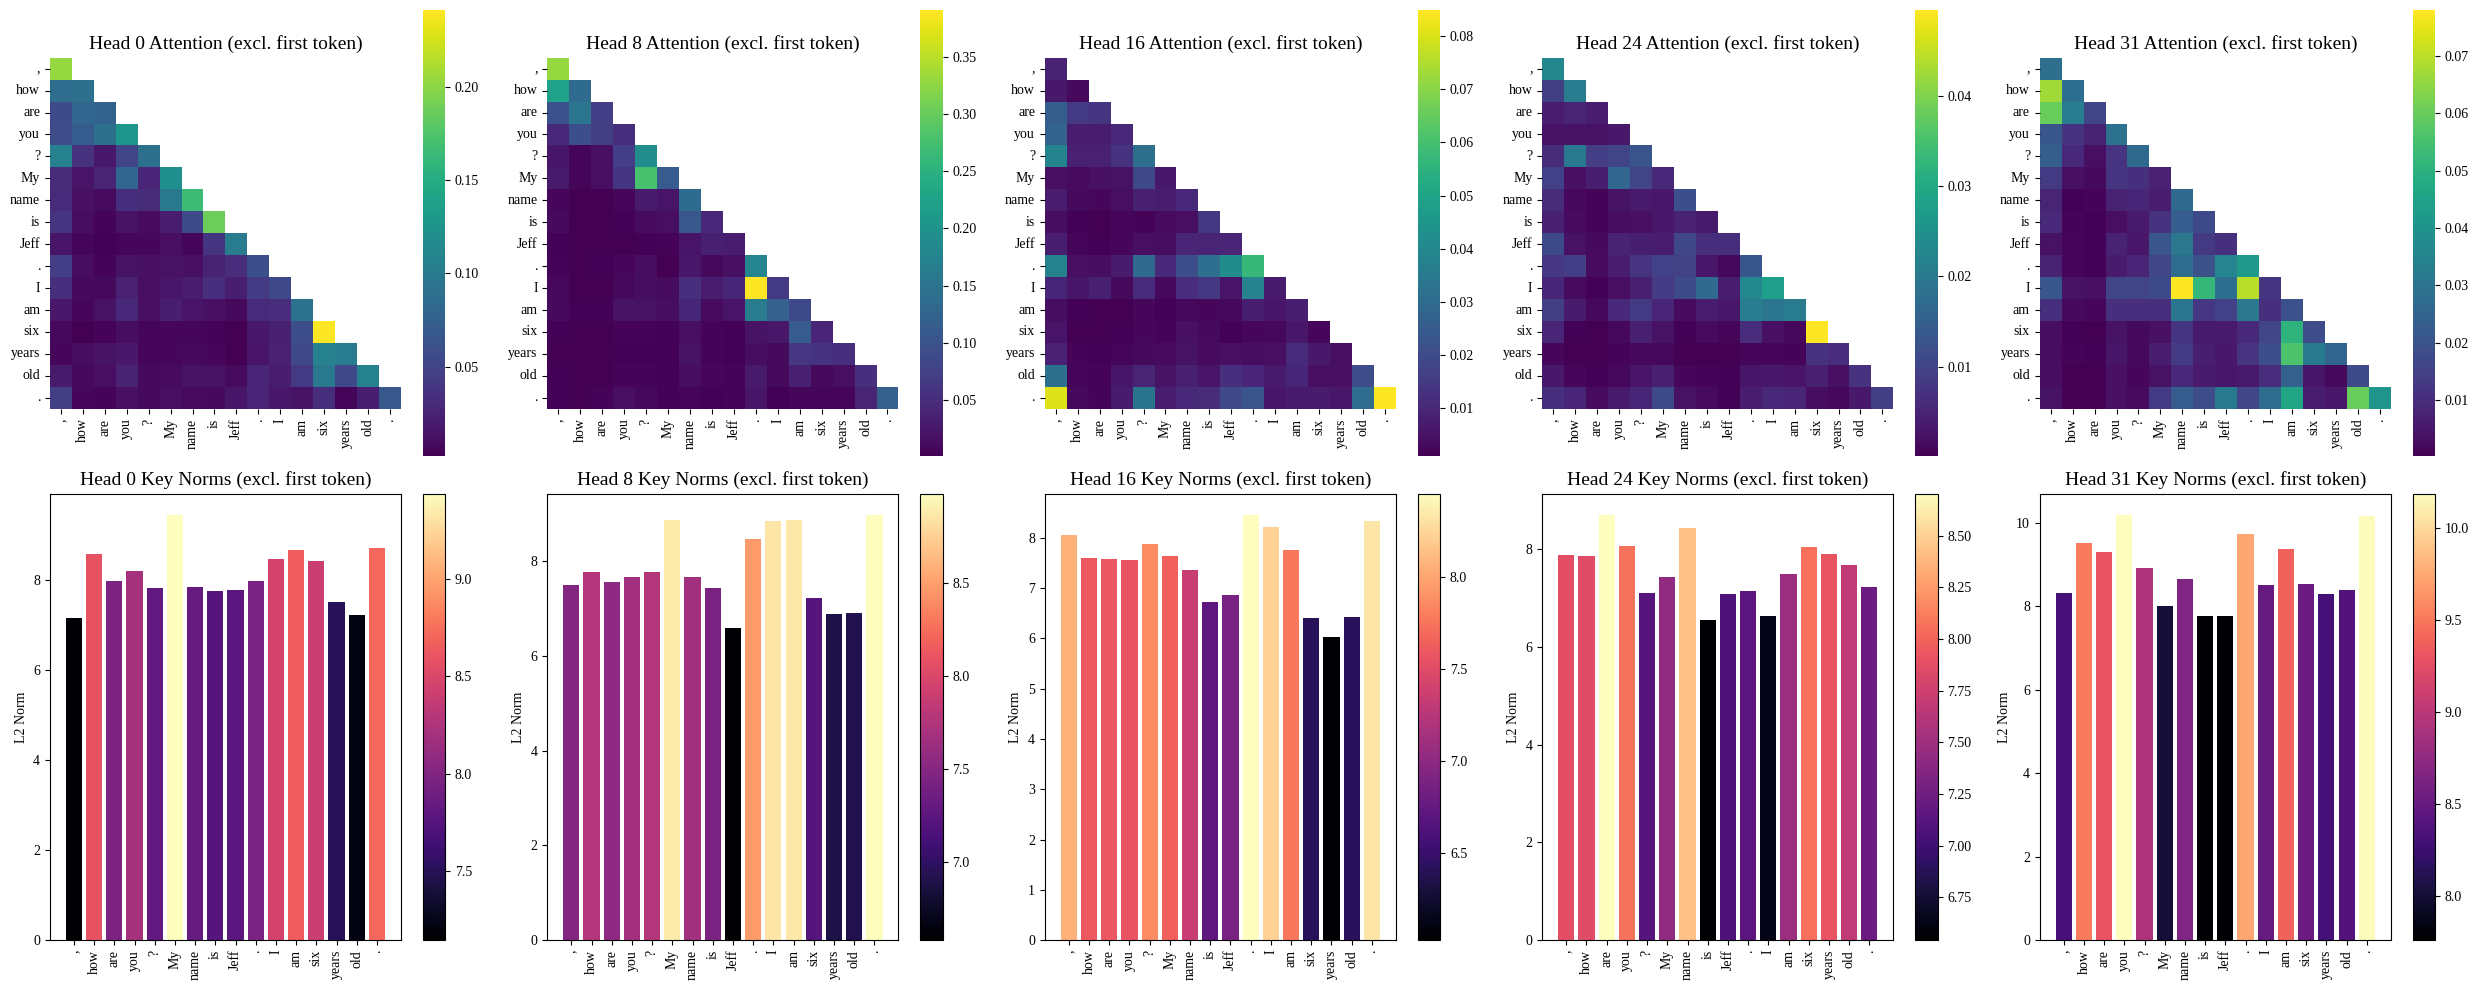

In [3]:
# imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from transformers.models.llama.modeling_llama import apply_rotary_pos_emb
from typing import List

# main class - Attention Correlation Analyzer
class AttentionCorrelationAnalyzer:
    def __init__(self, model_name: str, use_4bit: bool = True, access_token: str = None):
        # load the tokenizer for the specified model
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name,
            use_fast=True,
            use_auth_token=access_token,  # corrected parameter name
        )

        print("Loading model...")
        if use_4bit:
            # configure 4-bit quantization settings
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.float16,
            )
            # load the model with 4-bit quantization
            self.model = AutoModelForCausalLM.from_pretrained(
                model_name,
                device_map="auto",
                quantization_config=quantization_config,
                torch_dtype=torch.float16,
                low_cpu_mem_usage=True,
                use_auth_token=access_token,  # corrected parameter name
            )
        else:
            # load the model without quantization and enable attention outputs
            self.model = AutoModelForCausalLM.from_pretrained(
                model_name,
                device_map="auto",
                torch_dtype=torch.float16,
                low_cpu_mem_usage=True,
                use_auth_token=access_token,  # corrected parameter name
            )

        print("Model loaded successfully")
        # set the model to evaluation mode
        self.model.eval()
        # get the device where the model is loaded
        self.device = next(self.model.parameters()).device
        print(f"Model device: {self.device}")

        # list to store the captured data from hooks
        self.kv_captures = []

        # register hooks to capture key/value vectors without modifying them
        self._register_hooks()

    def _register_hooks(self):
        """
        register forward hooks to capture key/value vectors without modifying them.
        """
        def create_hook(layer_idx):
            def hook(module, input, output):
                # extract hidden states from the input to the layer
                hidden_states = input[0]  # shape: [batch_size, seq_len, hidden_size]
                batch_size, seq_len, _ = hidden_states.size()

                # access the self-attention module
                self_attn = module.self_attn

                # get head configurations
                head_dim = self_attn.head_dim
                num_heads = self_attn.num_heads
                num_kv_heads = self_attn.num_key_value_heads

                # log head configurations
                print(f"Layer {layer_idx}: num_heads={num_heads}, num_kv_heads={num_kv_heads}")

                # compute query, key, and value projections
                query_states = self_attn.q_proj(hidden_states)
                key_states = self_attn.k_proj(hidden_states)
                value_states = self_attn.v_proj(hidden_states)

                # reshape projections to separate heads
                query_states = query_states.view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)
                key_states = key_states.view(batch_size, seq_len, num_kv_heads, head_dim).transpose(1, 2)
                value_states = value_states.view(batch_size, seq_len, num_kv_heads, head_dim).transpose(1, 2)

                # apply rotary positional embeddings
                position_ids = torch.arange(seq_len, dtype=torch.long, device=hidden_states.device)
                position_ids = position_ids.unsqueeze(0).expand(batch_size, seq_len)
                cos, sin = self_attn.rotary_emb(query_states, position_ids=position_ids)
                query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

                # compute l2 norms of key vectors before normalization
                key_norms_before = torch.norm(key_states, dim=-1)  # shape: [batch_size, num_heads, seq_len]

                # **do not normalize key_states here**
                # key_states = torch.nn.functional.normalize(key_states, p=2, dim=-1)

                # if num_kv_heads != num_heads, adjust key_states and value_states
                if num_kv_heads != num_heads:
                    if num_heads % num_kv_heads != 0:
                        raise ValueError(f"num_heads ({num_heads}) is not divisible by num_kv_heads ({num_kv_heads})")
                    repeat_factor = num_heads // num_kv_heads
                    key_states = key_states.repeat_interleave(repeat_factor, dim=1)
                    value_states = value_states.repeat_interleave(repeat_factor, dim=1)
                    key_norms_before = key_norms_before.repeat_interleave(repeat_factor, dim=1)

                # store the captured data, including key vectors and norms
                self.kv_captures.append({
                    'layer': layer_idx,
                    'key_norms_before': key_norms_before.detach().cpu(),
                    'key_vectors': key_states.detach().cpu(),  # added for inspection
                })

                # debugging: print layer index and shapes
                print(f"Layer {layer_idx} captured key_norms_before shape: {key_norms_before.shape}")
                print(f"Layer {layer_idx} captured key_vectors shape: {key_states.shape}")

            return hook

        # register the hook function for each transformer layer
        for idx, layer in enumerate(self.model.model.layers):
            layer.register_forward_hook(create_hook(idx))
            print(f"Registered hook for layer {idx}")

    def visualize_attention_and_norms(self, prompt: str, layer: int, heads: List[int]):
        """
        visualize attention scores and l2 norms for a specific prompt, layer, and list of heads.

        args:
            prompt (str): the input prompt to analyze.
            layer (int): the layer to inspect (0-based index).
            heads (List[int]): list of head indices to visualize.
        """
        try:
            print(f"Processing prompt: {prompt[:50]}...")
            print(f"Visualizing layer {layer + 1}, heads {heads}")

            # reset captures
            self.kv_captures = []

            # tokenize the prompt without adding special tokens
            inputs = self.tokenizer(prompt, return_tensors="pt", add_special_tokens=False).to(self.device)
            input_ids = inputs.input_ids[0]
            tokens = self.tokenizer.convert_ids_to_tokens(input_ids)
            # remove 'Ġ' from tokens
            tokens = [token.replace('Ġ', '') for token in tokens]

            # perform a forward pass through the model with output_attentions=True
            with torch.no_grad():
                outputs = self.model(**inputs, output_attentions=True)

            # retrieve attentions from model outputs
            attentions = outputs.attentions  # tuple of attention weights from each layer

            # get attention from the specified layer
            layer_attention = attentions[layer]  # shape: [batch_size, num_heads, seq_len, seq_len]

            # find the capture for the specified layer
            capture = next((c for c in self.kv_captures if c['layer'] == layer), None)
            if capture is None:
                print(f"Layer {layer} data not found.")
                return

            # debugging: print shapes of captured data
            print(f"Captured key_norms_before shape: {capture['key_norms_before'].shape}")    # [batch_size, num_heads, seq_len]
            print(f"Captured key_vectors shape: {capture['key_vectors'].shape}")  # [batch_size, num_heads, seq_len, head_dim]

            # extract attention scores
            attn_probs = layer_attention[0]  # [num_heads, seq_len, seq_len]

            # extract key norms
            key_norms_before = capture['key_norms_before'][0]  # [num_heads, seq_len]
            key_vectors = capture['key_vectors'][0]  # [num_heads, seq_len, head_dim]

            # log key norms for all heads (optional)
            print(f"All key_norms_before for layer {layer}:")
            print(key_norms_before.numpy())

            # create copies of tokens and data for plots excluding the first token
            tokens_excl_first = tokens[1:]
            key_norms_before_excl_first = key_norms_before[:, 1:]
            attn_probs_excl_first = attn_probs[:, 1:, 1:]
            key_vectors_excl_first = key_vectors[:, 1:, :]

            # visualization for all tokens
            """
            self._plot_attention_and_norms(
                tokens,
                heads,
                attn_probs,
                key_norms_before,
                key_vectors,
                layer
            )
            """

            # visualization excluding the first token
            self._plot_attention_and_norms(
                tokens_excl_first,
                heads,
                attn_probs_excl_first,
                key_norms_before_excl_first,
                key_vectors_excl_first,
                layer,
                exclude_first=True
            )

        except Exception as e:
            print(f"An error occurred during visualization: {e}")

    def _plot_attention_and_norms(
        self,
        tokens: List[str],
        heads: List[int],
        attn_probs: torch.Tensor,
        key_norms_before: torch.Tensor,
        key_vectors: torch.Tensor,
        layer: int,
        exclude_first: bool = False
    ):
        """
        helper function to plot attention scores and key norms.

        args:
            tokens (List[str]): list of tokens.
            heads (List[int]): list of head indices.
            attn_probs (torch.Tensor): attention probabilities.
            key_norms_before (torch.Tensor): key norms before normalization.
            key_vectors (torch.Tensor): key vectors.
            layer (int): layer index.
            exclude_first (bool): whether the first token is excluded.
        """
        num_heads = len(heads)
        fig, axs = plt.subplots(2, num_heads, figsize=(5 * num_heads, 10))

        for idx, head_idx in enumerate(heads):
            # ensure head_idx is within the valid range
            if head_idx >= attn_probs.shape[0]:
                print(f"Head index {head_idx} is out of range for layer {layer}. Skipping.")
                if num_heads == 1:
                    axs.axis('off')
                else:
                    axs[0, idx].axis('off')
                    axs[1, idx].axis('off')
                continue

            # attention probabilities for this head
            attn_head = attn_probs[head_idx].cpu().numpy()  # [seq_len, seq_len]
            # mask upper triangle to focus on lower triangle (causal attention)
            attn_head_masked = np.tril(attn_head, k=0)

            # plot attention scores (lower triangle)
            sns.heatmap(
                attn_head_masked,
                ax=axs[0, idx] if num_heads > 1 else axs,
                cmap='viridis',
                cbar=True,
                xticklabels=tokens,
                yticklabels=tokens,
                square=True,
                annot=False,
                mask=attn_head_masked == 0
            )
            axs[0, idx].set_xticklabels(axs[0, idx].get_xticklabels(), rotation=90)
            axs[0, idx].set_yticklabels(axs[0, idx].get_yticklabels(), rotation=0)
            title_suffix = " (excl. first token)" if exclude_first else ""
            axs[0, idx].set_title(f'Head {head_idx} Attention{title_suffix}', fontsize=14)

            # key norms for this head
            key_norm_before = key_norms_before[head_idx].numpy().astype(np.float64)  # [seq_len]

            # normalize key norms for color mapping
            norm = plt.Normalize(key_norm_before.min(), key_norm_before.max())
            colors = plt.cm.magma(norm(key_norm_before))

            # plot l2 norms as bar plot with color shading
            axs[1, idx].bar(range(len(key_norm_before)), key_norm_before, color=colors)
            axs[1, idx].set_xticks(range(len(key_norm_before)))
            axs[1, idx].set_xticklabels(tokens, rotation=90)
            axs[1, idx].set_title(f'Head {head_idx} Key Norms{title_suffix}', fontsize=14)
            axs[1, idx].set_ylabel('L2 Norm')

            # add color bar for the l2 norms
            sm = plt.cm.ScalarMappable(cmap='magma', norm=norm)
            sm.set_array([])
            fig.colorbar(sm, ax=axs[1, idx])

            # debugging: print key norms and inspect key vectors
            print(f"\nHead {head_idx} Key Norms Before Normalization{ ' (excl. first token)' if exclude_first else ''}:\n", key_norm_before)

            if exclude_first:
                print(f"\nHead {head_idx} Key Vectors for Layer {layer} (excl. first token):")
                print(key_vectors[head_idx].numpy())
            else:
                print(f"\nHead {head_idx} Key Vectors for Layer {layer}:")
                print(key_vectors[head_idx].numpy())

            # optional: compute correlation between key norms and attention scores
            # here, we compute the correlation between key_norm_before and the sum of attention scores per key
            # sum attention scores per key (i.e., sum over query positions)
            attention_sum_per_key = attn_head.sum(axis=0)  # [seq_len]
            correlation = np.corrcoef(key_norm_before, attention_sum_per_key)[0, 1]
            print(f"Correlation between key norms and attention sums for Head {head_idx}{ ' (excl. first token)' if exclude_first else ''}: {correlation:.4f}")

        plt.tight_layout()
        plt.show()

# usage example
if __name__ == "__main__":

    model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

    # clear cuda cache
    torch.cuda.empty_cache()

    # instantiate the analyzer without quantization for testing
    analyzer = AttentionCorrelationAnalyzer(model_name, use_4bit=False, access_token=access_token)

    # define a simplified prompt
    specific_prompt = "Hello, how are you? My name is Jeff. I am six years old."

    # specify the layer and heads to visualize (layer 20 corresponds to index 20)
    layer_to_visualize = 20  # layer index (0-based)
    heads_to_visualize = [0, 8, 16, 24, 31]  # example heads, adjust as needed

    # visualize attention and norms for the specified prompt, layer, and heads
    analyzer.visualize_attention_and_norms(specific_prompt, layer_to_visualize, heads_to_visualize)

    # clear cuda cache
    torch.cuda.empty_cache()


# Figure 9 (a)-(d)

Loading model...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model loaded without quantization.
Model loaded successfully.
Model device: cuda:0


README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Using 3 random Gaussian projections (hash tables) for each projection length.
Computing Hamming distances and averaging across projections to reduce variance.


Processing Prompts: 100%|██████████| 50/50 [12:16<00:00, 14.74s/it]


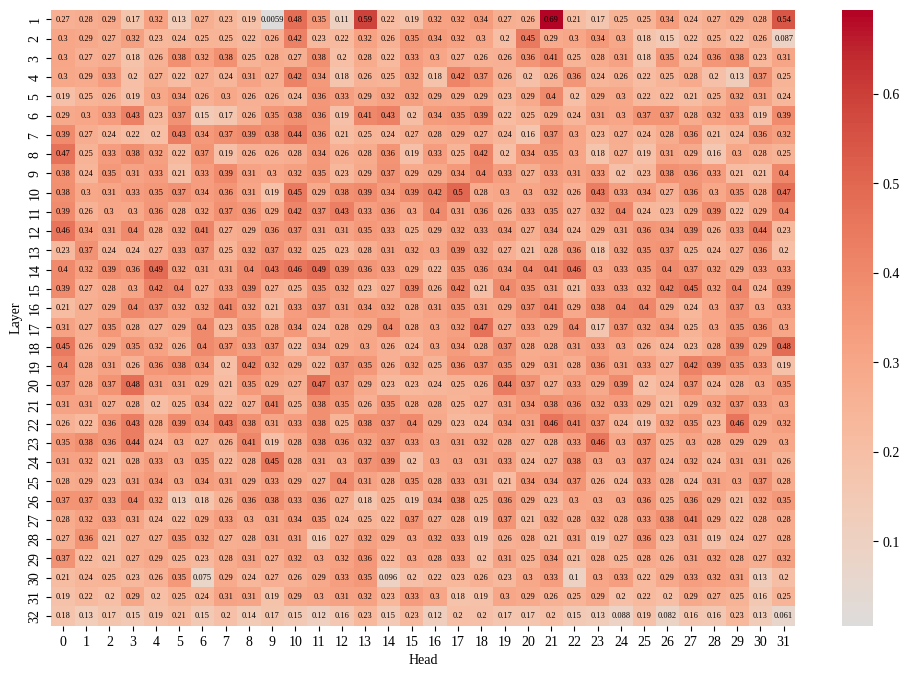

Overall Average Pearson Correlation (Inverted): 0.2978 ± 0.1947

Average Pearson Correlation (Inverted) per Projection Length:
   Projection Length      mean       std
0                  8  0.201737  0.188988
1                 16  0.279337  0.185195
2                 24  0.334528  0.180630
3                 32  0.375399  0.179240


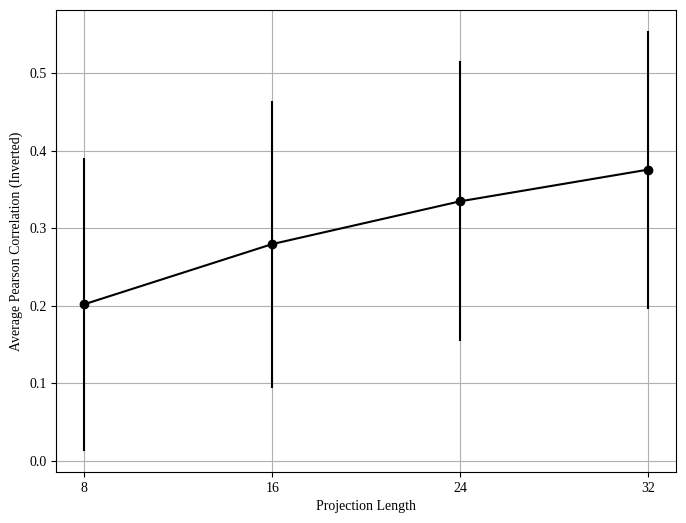

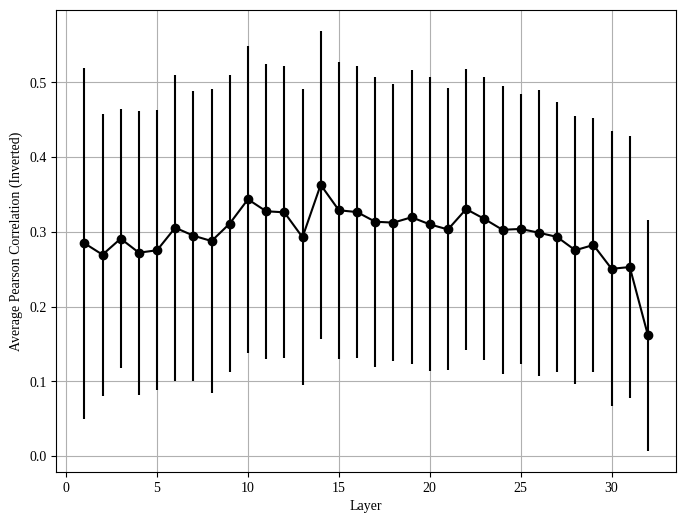

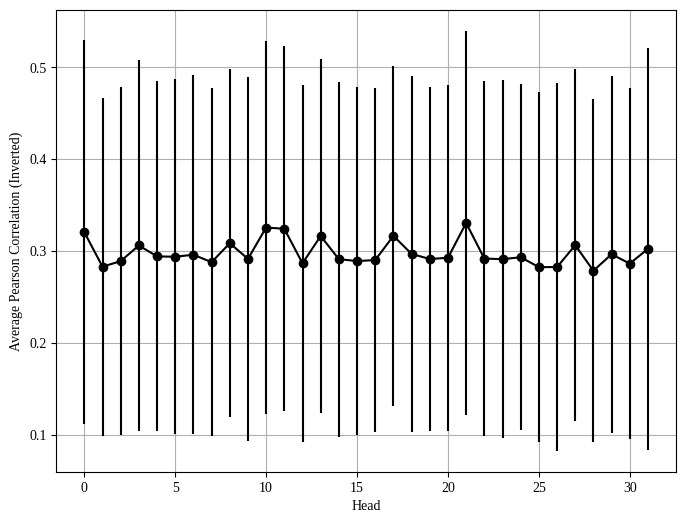

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import math
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from transformers.models.llama.modeling_llama import apply_rotary_pos_emb
from typing import List
from tqdm import tqdm
from datasets import load_dataset
import pandas as pd

# define rotate_half as it's used in apply_rotary_pos_emb
def rotate_half(x):
    """
    rotates the last dimension halfway.
    """
    x1 = x[..., : x.size(-1) // 2]
    x2 = x[..., x.size(-1) // 2 :]
    return torch.cat((-x2, x1), dim=-1)

# main class - attention correlation analyzer
class AttentionCorrelationAnalyzer:
    def __init__(self, model_name: str, use_4bit: bool = True, access_token: str = None):
        # load the tokenizer for the specified model
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name,
            use_fast=True,
            token=access_token,
        )

        print("Loading model...")
        if use_4bit:
            # configure 4-bit quantization settings
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.float16,
            )
            # load the model with 4-bit quantization
            try:
                self.model = AutoModelForCausalLM.from_pretrained(
                    model_name,
                    device_map="auto",
                    quantization_config=quantization_config,
                    torch_dtype=torch.float16,
                    low_cpu_mem_usage=True,
                    token=access_token,
                )
                print("Model loaded with 4-bit quantization.")
            except Exception as e:
                print(f"Error loading model with 4-bit quantization: {e}")
                print("Attempting to load model without quantization.")
                self.model = AutoModelForCausalLM.from_pretrained(
                    model_name,
                    device_map="auto",
                    torch_dtype=torch.float16,
                    low_cpu_mem_usage=True,
                    token=access_token,
                )
                print("Model loaded without quantization.")
                use_4bit = False  # update flag since quantization failed
        else:
            # load the model without quantization
            self.model = AutoModelForCausalLM.from_pretrained(
                model_name,
                device_map="auto",
                torch_dtype=torch.float16,
                low_cpu_mem_usage=True,
                token=access_token,
            )
            print("Model loaded without quantization.")

        print("Model loaded successfully.")
        # set the model to evaluation mode
        self.model.eval()
        # get the device where the model is loaded
        self.device = next(self.model.parameters()).device
        print(f"Model device: {self.device}")

        # list to store the captured data from hooks
        self.kv_captures = []

        # register hooks to capture key/value vectors and attention scores
        self._register_hooks()

    def _register_hooks(self):
        """
        register forward hooks to capture key/value vectors and attention scores.
        """
        def create_hook(layer_idx):
            def hook(module, input, output):
                # ensure input has at least one element
                if len(input) < 1:
                    print(f"Layer {layer_idx}: unexpected input format: {input}")
                    return

                # extract hidden states from the input to the layer
                hidden_states = input[0]  # shape: [batch_size, seq_len, hidden_size]
                batch_size, seq_len, _ = hidden_states.size()

                # access the self-attention module
                self_attn = module.self_attn

                # compute query, key, and value projections
                query_states = self_attn.q_proj(hidden_states)
                key_states = self_attn.k_proj(hidden_states)
                value_states = self_attn.v_proj(hidden_states)

                # get actual head dimensions based on the projection sizes
                head_dim = self_attn.head_dim
                num_heads = self_attn.num_heads
                num_kv_heads = getattr(self_attn, 'num_key_value_heads', None)

                if num_kv_heads is None:
                    # if 'num_key_value_heads' attribute doesn't exist, assume it's equal to num_heads
                    num_kv_heads = num_heads
                else:
                    pass  # 'num_key_value_heads' is found

                # reshape projections to separate heads
                query_states = query_states.view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)  # [batch, num_heads, seq_len, head_dim]
                key_states = key_states.view(batch_size, seq_len, num_kv_heads, head_dim).transpose(1, 2)      # [batch, num_kv_heads, seq_len, head_dim]
                value_states = value_states.view(batch_size, seq_len, num_kv_heads, head_dim).transpose(1, 2)  # [batch, num_kv_heads, seq_len, head_dim]

                # handle grouped query attention by repeating key/value heads before applying rotary pos emb
                if num_kv_heads != num_heads:
                    if num_heads % num_kv_heads != 0:
                        raise ValueError(f"num_heads ({num_heads}) is not divisible by num_kv_heads ({num_kv_heads})")
                    repeat_factor = num_heads // num_kv_heads
                    # correctly replicate key_states and value_states using torch.cat
                    key_states = torch.cat([key_states] * repeat_factor, dim=1)      # [batch, num_heads, seq_len, head_dim]
                    value_states = torch.cat([value_states] * repeat_factor, dim=1)  # [batch, num_heads, seq_len, head_dim]
                else:
                    pass  # no replication needed

                # apply rotary positional embeddings
                position_ids = torch.arange(seq_len, dtype=torch.long, device=hidden_states.device)
                position_ids = position_ids.unsqueeze(0).expand(batch_size, seq_len)  # [batch, seq_len]
                cos, sin = self_attn.rotary_emb(value_states, position_ids=position_ids)
                query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

                # compute attention scores
                attn_scores = torch.matmul(query_states, key_states.transpose(-1, -2))  # [batch, num_heads, seq_len, seq_len]

                # scale attention scores by sqrt(head_dim)
                attn_scores = attn_scores / math.sqrt(head_dim)

                # apply causal mask to attention scores
                causal_mask = torch.triu(torch.full((seq_len, seq_len), float('-inf'), device=attn_scores.device), diagonal=1)
                attn_scores = attn_scores + causal_mask.unsqueeze(0).unsqueeze(0)  # [batch, num_heads, seq_len, seq_len]

                # apply softmax to get attention probabilities
                attn_probs = torch.nn.functional.softmax(attn_scores, dim=-1)  # [batch, num_heads, seq_len, seq_len]

                # store the captured data
                self.kv_captures.append({
                    'layer': layer_idx,
                    'attn_probs': attn_probs.detach().cpu(),
                    'key_states': key_states.detach().cpu(),        # captured key states
                    'query_states': query_states.detach().cpu(),    # captured query states
                })

            return hook

        # register the hook function for each transformer layer
        for idx, layer in enumerate(self.model.model.layers):
            layer.register_forward_hook(create_hook(idx))

    def visualize_attention_and_norms_varying_lsh(
        self, prompt: str, layer: int, heads: List[int], projection_lengths: List[int],
        compute_all_heads_layers: bool = False,  # New parameter to control computation scope
        num_projections: int = 3  # Number of projections to use
    ):
        """
        visualize how varying lsh projection lengths affect the correlation between attention scores
        and average hamming distances.

        args:
            prompt (str): the input prompt to analyze.
            layer (int): the layer to inspect (0-based index).
            heads (list[int]): list of head indices to visualize.
            projection_lengths (list[int]): list of projection lengths to test.
            compute_all_heads_layers (bool): if True, computes correlations for all heads and layers.
            num_projections (int): number of projections to use for averaging.
        """
        # reset captures
        self.kv_captures = []

        # tokenize the prompt with special tokens
        inputs = self.tokenizer(prompt, return_tensors="pt", add_special_tokens=True).to(self.device)
        input_ids = inputs.input_ids[0]
        bos_token_id = self.tokenizer.bos_token_id

        # identify indices excluding the bos token and move to cpu for indexing
        non_bos_indices = (input_ids != bos_token_id).nonzero(as_tuple=True)[0].cpu()
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids[non_bos_indices])
        tokens = [token.replace('Ġ', '') for token in tokens]  # Remove 'Ġ' for readability

        # perform a forward pass through the model
        with torch.no_grad():
            outputs = self.model(**inputs)

        seq_len = inputs.input_ids.size(1)

        # initialize data structures to collect correlations
        all_correlations = []

        # determine layers and heads to process
        if compute_all_heads_layers:
            layers_to_process = range(len(self.model.model.layers))
        else:
            layers_to_process = [layer]

        # iterate over each layer
        for layer_idx in layers_to_process:
            # find the capture for the specified layer
            capture = next((c for c in self.kv_captures if c['layer'] == layer_idx), None)
            if capture is None:
                continue

            # adjust captured data to exclude bos token
            attn_probs = capture['attn_probs'][0][:, non_bos_indices][:, :, non_bos_indices]  # [num_heads, seq_len-1, seq_len-1]
            key_states = capture['key_states'][0][:, non_bos_indices, :]  # [num_heads, seq_len-1, head_dim]
            query_states = capture['query_states'][0][:, non_bos_indices, :]  # [num_heads, seq_len-1, head_dim]

            num_heads_in_layer = attn_probs.shape[0]

            # set the heads to process
            if compute_all_heads_layers:
                heads_to_process = range(num_heads_in_layer)
            else:
                heads_to_process = heads

            # iterate over each head
            for head_idx in heads_to_process:
                if head_idx >= num_heads_in_layer:
                    continue

                # get attention scores for this head
                attn_head = attn_probs[head_idx]  # [seq_len-1, seq_len-1]

                # get key and query states for this head
                key_states_head = key_states[head_idx]    # [seq_len-1, head_dim]
                query_states_head = query_states[head_idx]  # [seq_len-1, head_dim]

                # normalize key and query vectors
                key_states_head_norm = key_states_head / key_states_head.norm(dim=1, keepdim=True)
                query_states_head_norm = query_states_head / query_states_head.norm(dim=1, keepdim=True)

                # get the decoded token's query vector (last token)
                decoded_token_query = query_states_head_norm[-1]   # [head_dim]

                # set random seed for reproducibility
                torch.manual_seed(42)
                np.random.seed(42)

                # get attention scores from the decoded token to all keys
                attn_scores = attn_head[-1, :].numpy()  # [seq_len-1]

                # iterate over each projection length
                for proj_dim in projection_lengths:
                    # generate random gaussian projection matrices and normalize them column-wise
                    random_projections = [
                        torch.nn.functional.normalize(
                            torch.randn(decoded_token_query.size(0), proj_dim, dtype=decoded_token_query.dtype),
                            p=2,
                            dim=0
                        ) for _ in range(num_projections)
                    ]

                    # project and binarize the decoded token's query vector
                    decoded_proj = [
                        ((decoded_token_query @ proj) > 0).int() for proj in random_projections
                    ]  # list of [proj_dim]

                    # project and binarize all key vectors
                    keys_proj = [
                        ((key_states_head_norm @ proj) > 0).int() for proj in random_projections
                    ]  # list of [seq_len-1, proj_dim]

                    hamming_distances_all = []

                    # compute hamming distances for each projection
                    for proj_idx in range(num_projections):
                        # broadcast decoded_proj to match keys_proj dimensions
                        decoded = decoded_proj[proj_idx].unsqueeze(0)  # [1, proj_dim]
                        keys = keys_proj[proj_idx]                     # [seq_len-1, proj_dim]
                        # compute hamming distance
                        hamming = (decoded != keys).sum(dim=1).float() / proj_dim  # [seq_len-1]
                        hamming_distances_all.append(hamming)

                    # average hamming distances across projections
                    average_hamming_distances = torch.stack(hamming_distances_all).mean(dim=0).numpy()  # [seq_len-1]

                    # invert hamming distances for correlation
                    inverted_hamming_distances = 1 - average_hamming_distances

                    # compute pearson correlation with raw hamming distances
                    correlation, p_value = pearsonr(attn_scores, average_hamming_distances)

                    # compute pearson correlation with inverted hamming distances
                    correlation_inverted, p_value_inverted = pearsonr(attn_scores, inverted_hamming_distances)

                    # store the results
                    all_correlations.append({
                        'Layer': layer_idx + 1,  # Convert to 1-based indexing
                        'Head': head_idx,
                        'Projection Length': proj_dim,
                        'Correlation (Raw)': correlation,
                        'Correlation (Inverted)': correlation_inverted,
                        'Prompt': prompt[:50],
                        'Attention_Probs': attn_probs,
                        'Attention Scores': attn_scores# Store a snippet of the prompt for reference
                    })

        return all_correlations # Return the collected correlations

# function to process multiple prompts and aggregate correlations
def process_prompts(analyzer, prompts, projection_lengths, num_projections=3):
    """
    Processes multiple prompts and aggregates correlations across layers and heads.

    Args:
        analyzer: An instance of AttentionCorrelationAnalyzer.
        prompts (list): List of prompts to process.
        projection_lengths (list): List of projection lengths to test.
        num_projections (int): Number of projections to use for averaging.

    Returns:
        DataFrame containing correlations for all prompts, layers, and heads.
    """
    all_results = []

    print(f"Using {num_projections} random Gaussian projections (hash tables) for each projection length.")
    print("Computing Hamming distances and averaging across projections to reduce variance.")

    for prompt in tqdm(prompts, desc="Processing Prompts"):
        correlations = analyzer.visualize_attention_and_norms_varying_lsh(
            prompt,
            layer=0,  # placeholder; actual layer indices are handled inside the method
            heads=[],
            projection_lengths=projection_lengths,
            compute_all_heads_layers=True,
            num_projections=num_projections
        )
        all_results.extend(correlations)

    df_results = pd.DataFrame(all_results)
    return df_results, correlations

# function to generate aggregated tables and heatmaps
def generate_reports(df_results):
    """
    Generates aggregated tables and heatmaps from the results.

    Args:
        df_results (DataFrame): DataFrame containing correlations.

    Returns:
        None
    """
    # specify the numeric columns to include in the mean calculation
    numeric_columns = ['Correlation (Raw)', 'Correlation (Inverted)']

    # compute average correlations per layer and head
    df_grouped = df_results.groupby(['Layer', 'Head'])[numeric_columns].mean().reset_index()

    # pivot table for heatmap (Correlation with Inverted Hamming Distances)
    pivot_table = df_grouped.pivot(index='Layer', columns='Head', values='Correlation (Inverted)')

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        pivot_table,
        annot=True,
        annot_kws={"size": 6, "color": "black"},  # reduced font size and set text color to black
        cmap='coolwarm',
        center=0
    )
    # plt.title('Average Pearson Correlation between Attention Scores and Inverted Average Hamming Distances\nAcross Layers and Heads', color='black')
    plt.xlabel('Head', color='black')
    plt.ylabel('Layer', color='black')
    plt.xticks(color='black')
    plt.yticks(color='black')
    plt.show()

    # overall average correlation
    overall_avg_corr = df_results['Correlation (Inverted)'].mean()
    overall_std_corr = df_results['Correlation (Inverted)'].std()
    print(f"Overall Average Pearson Correlation (Inverted): {overall_avg_corr:.4f} ± {overall_std_corr:.4f}")

    # compute average correlation per projection length
    df_proj_grouped = df_results.groupby('Projection Length')['Correlation (Inverted)'].agg(['mean', 'std']).reset_index()

    # print average correlation per projection length
    print("\nAverage Pearson Correlation (Inverted) per Projection Length:")
    print(df_proj_grouped)

    # plot average correlation vs. projection length
    plt.figure(figsize=(8, 6))
    plt.errorbar(df_proj_grouped['Projection Length'], df_proj_grouped['mean'], yerr=df_proj_grouped['std'], fmt='-o', color='black')
    # plt.title('Average Pearson Correlation vs. Projection Length', color='black')
    plt.xlabel('Projection Length', color='black')
    plt.ylabel('Average Pearson Correlation (Inverted)', color='black')
    plt.grid(True)
    plt.xticks([8, 16, 24, 32], color='black')
    plt.yticks(color='black')
    plt.show()

    # compute average correlation per layer
    df_layer_grouped = df_results.groupby('Layer')['Correlation (Inverted)'].agg(['mean', 'std']).reset_index()

    # plot average correlation per layer
    plt.figure(figsize=(8, 6))
    plt.errorbar(df_layer_grouped['Layer'], df_layer_grouped['mean'], yerr=df_layer_grouped['std'], fmt='-o', color='black')
    # plt.title('Average Pearson Correlation vs. Layer', color='black')
    plt.xlabel('Layer', color='black')
    plt.ylabel('Average Pearson Correlation (Inverted)', color='black')
    plt.grid(True)
    plt.xticks(color='black')
    plt.yticks(color='black')
    plt.show()

    # compute average correlation per head
    df_head_grouped = df_results.groupby('Head')['Correlation (Inverted)'].agg(['mean', 'std']).reset_index()

    # plot average correlation per head
    plt.figure(figsize=(8, 6))
    plt.errorbar(df_head_grouped['Head'], df_head_grouped['mean'], yerr=df_head_grouped['std'], fmt='-o', color='black')
    # plt.title('Average Pearson Correlation vs. Head', color='black')
    plt.xlabel('Head', color='black')
    plt.ylabel('Average Pearson Correlation (Inverted)', color='black')
    plt.grid(True)
    plt.xticks(color='black')
    plt.yticks(color='black')
    plt.show()


if __name__ == "__main__":
    model_name = "meta-llama/Meta-Llama-3-8B-Instruct"


    # clear cuda cache
    torch.cuda.empty_cache()

    # instantiate the analyzer
    analyzer = AttentionCorrelationAnalyzer(model_name, use_4bit=False, access_token=access_token)

    # load the dataset and sample 50 prompts for testing
    dataset = load_dataset('gsm8k', 'main', split='train')

    # shuffle and select 50 samples for quicker testing
    sampled_data = dataset.shuffle(seed=42).select(range(50))

    # extract prompts (questions)
    prompts = [sample['question'] for sample in sampled_data]

    # define projection lengths to test
    projection_lengths = [8, 16, 24, 32]

    # process prompts and collect correlations
    df_results = process_prompts(analyzer, prompts, projection_lengths)

    # generate reports
    generate_reports(df_results[0])

    # clear cuda cache
    torch.cuda.empty_cache()


# Figures 10 (a) and (b)

loading model...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

model loaded without quantization.
model loaded successfully.
model device: cuda:0
registered hook for layer 0.
registered hook for layer 1.
registered hook for layer 2.
registered hook for layer 3.
registered hook for layer 4.
registered hook for layer 5.
registered hook for layer 6.
registered hook for layer 7.
registered hook for layer 8.
registered hook for layer 9.
registered hook for layer 10.
registered hook for layer 11.
registered hook for layer 12.
registered hook for layer 13.
registered hook for layer 14.
registered hook for layer 15.
registered hook for layer 16.
registered hook for layer 17.
registered hook for layer 18.
registered hook for layer 19.
registered hook for layer 20.
registered hook for layer 21.
registered hook for layer 22.
registered hook for layer 23.
registered hook for layer 24.
registered hook for layer 25.
registered hook for layer 26.
registered hook for layer 27.
registered hook for layer 28.
registered hook for layer 29.
registered hook for layer 3

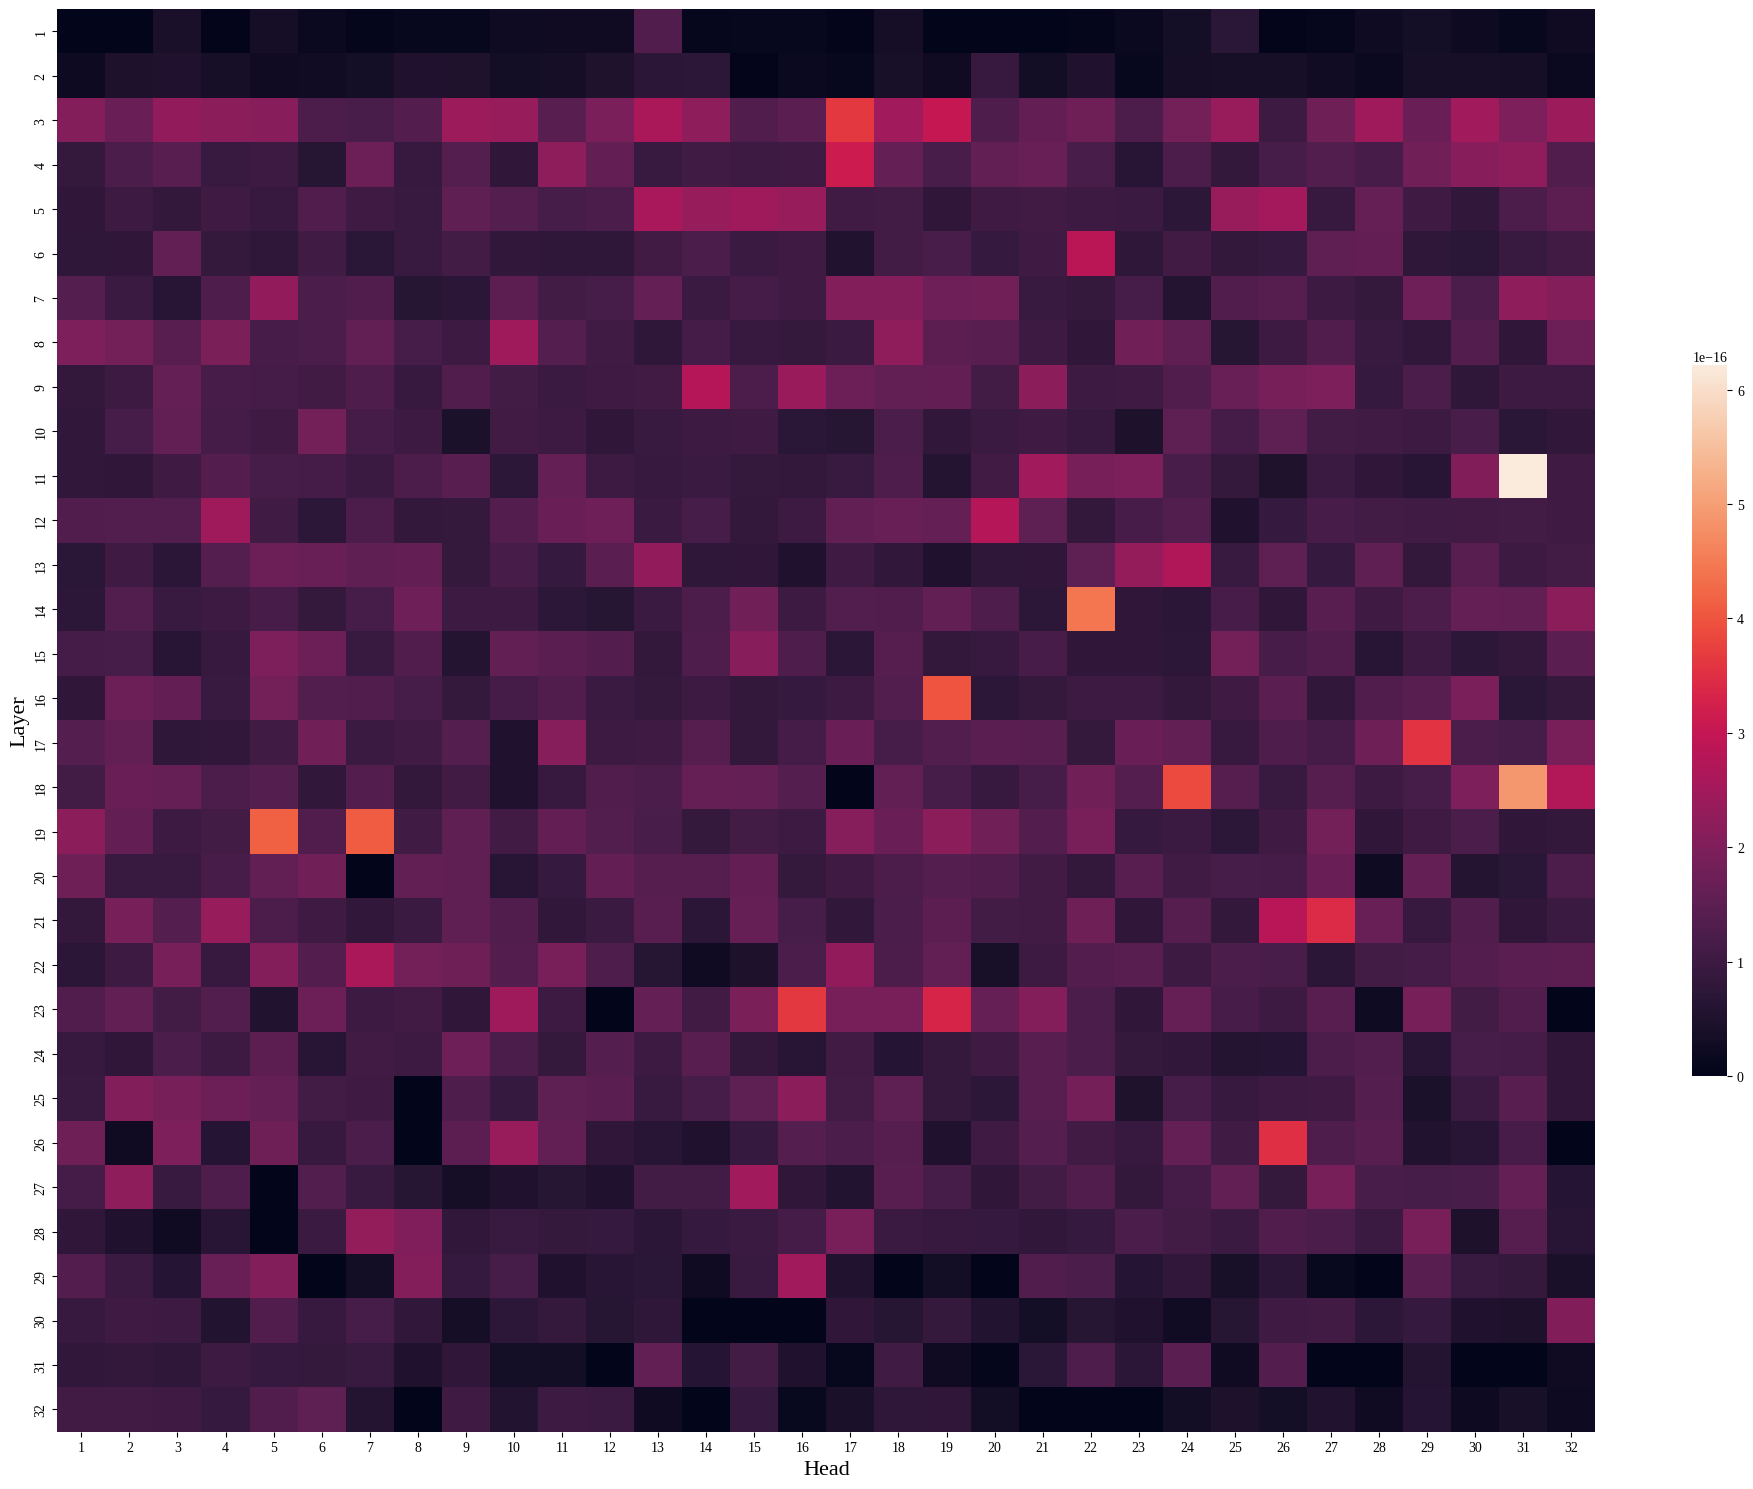


Computing ALR with LSH projection length 16 and generating heatmap...

processing prompt: Stefan goes to a restaurant to eat dinner with his...

processing prompt: The gauge on a water tank shows that the tank is 1...

processing prompt: Ben has 8 apples more than Phillip does. Tom has t...

processing prompt: John wants to start a zoo.  He has 15 snakes.  He ...

processing prompt: A portable battery charger can fully charge a smar...

processing prompt: Darla needs to pay $4/watt of electricity for 300 ...

processing prompt: There have been 15 "Where's Waldo?" books publishe...

processing prompt: Bart makes a mixtape.  The first side has 6 songs....

processing prompt: An old pirate wants to leave his treasure on an is...

processing prompt: New York recorded 5000 new coronavirus cases on a ...

processing prompt: Brady will make $450 more in a year than Dwayne. I...

processing prompt: Carolyn is planning out her final essay. The intro...

processing prompt: Marie has 98 unread m

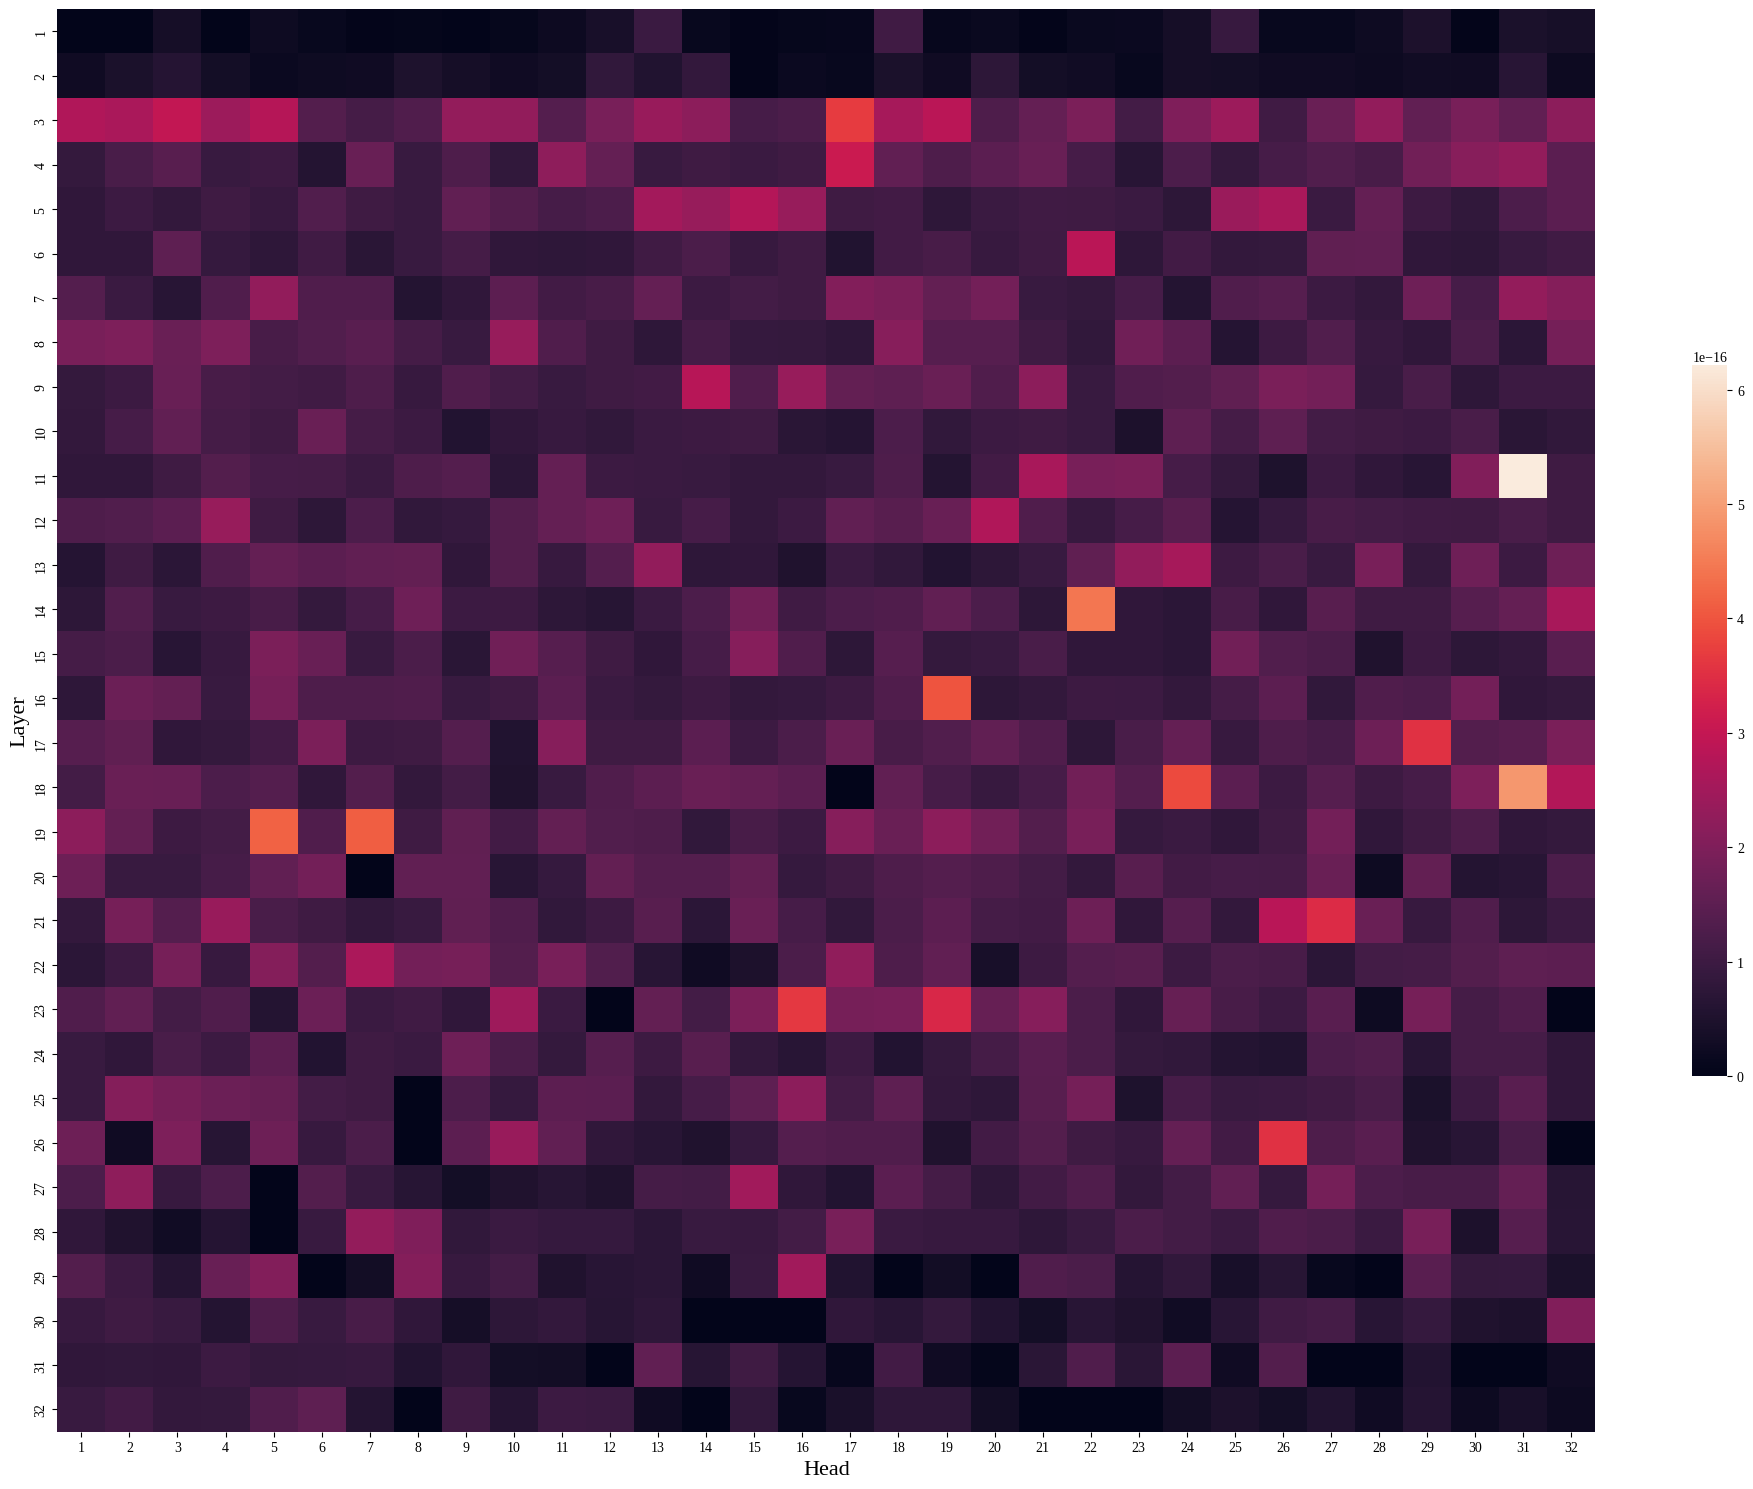


Computing ALR with LSH projection length 24 and generating heatmap...

processing prompt: Stefan goes to a restaurant to eat dinner with his...

processing prompt: The gauge on a water tank shows that the tank is 1...

processing prompt: Ben has 8 apples more than Phillip does. Tom has t...

processing prompt: John wants to start a zoo.  He has 15 snakes.  He ...

processing prompt: A portable battery charger can fully charge a smar...

processing prompt: Darla needs to pay $4/watt of electricity for 300 ...

processing prompt: There have been 15 "Where's Waldo?" books publishe...

processing prompt: Bart makes a mixtape.  The first side has 6 songs....

processing prompt: An old pirate wants to leave his treasure on an is...

processing prompt: New York recorded 5000 new coronavirus cases on a ...

processing prompt: Brady will make $450 more in a year than Dwayne. I...

processing prompt: Carolyn is planning out her final essay. The intro...

processing prompt: Marie has 98 unread m

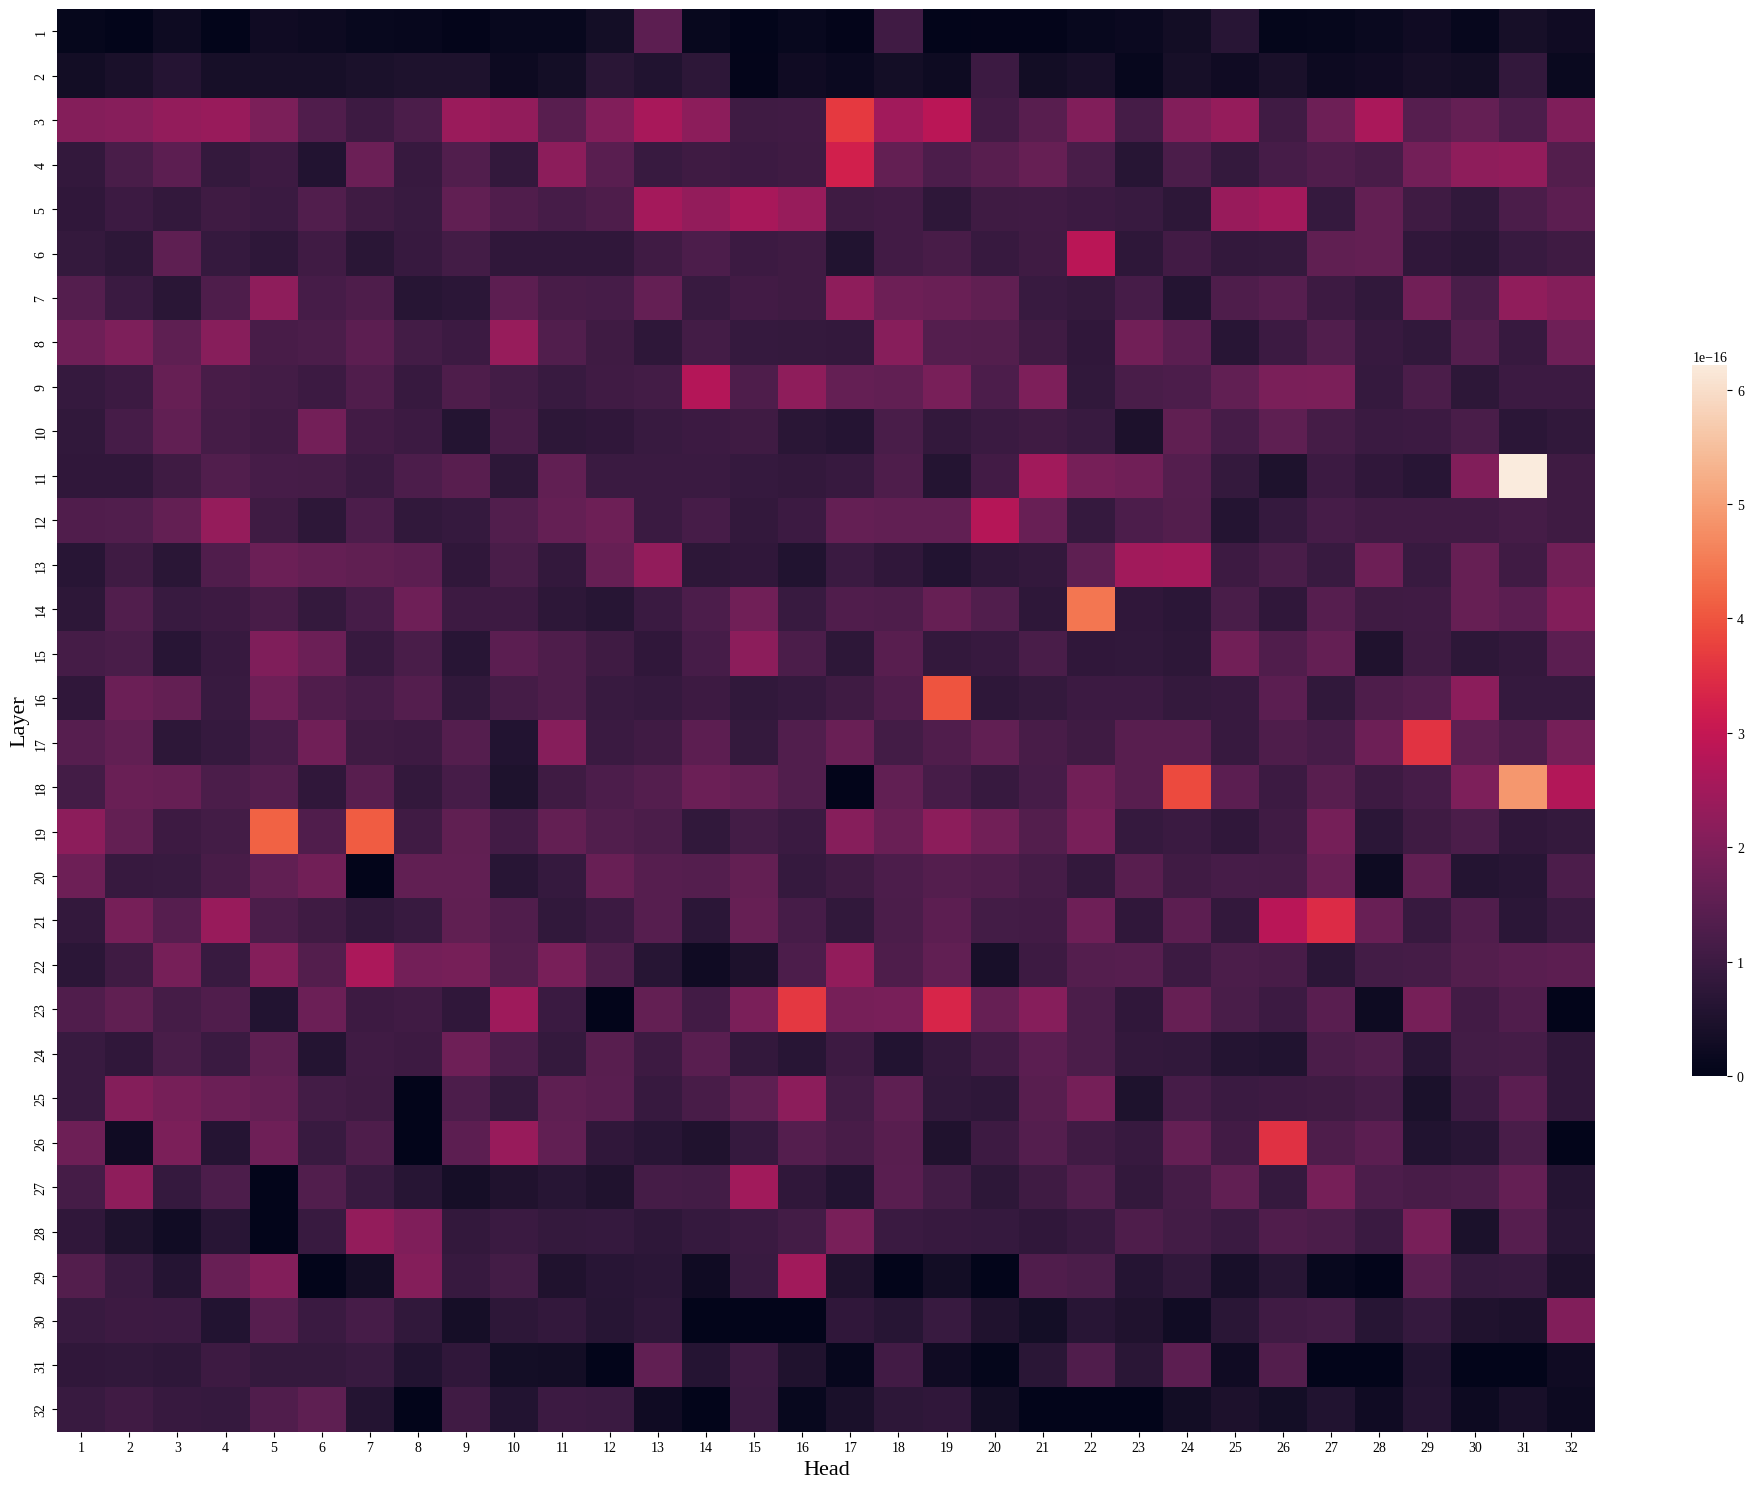


Computing ALR with LSH projection length 32 and generating heatmap...

processing prompt: Stefan goes to a restaurant to eat dinner with his...

processing prompt: The gauge on a water tank shows that the tank is 1...

processing prompt: Ben has 8 apples more than Phillip does. Tom has t...

processing prompt: John wants to start a zoo.  He has 15 snakes.  He ...

processing prompt: A portable battery charger can fully charge a smar...

processing prompt: Darla needs to pay $4/watt of electricity for 300 ...

processing prompt: There have been 15 "Where's Waldo?" books publishe...

processing prompt: Bart makes a mixtape.  The first side has 6 songs....

processing prompt: An old pirate wants to leave his treasure on an is...

processing prompt: New York recorded 5000 new coronavirus cases on a ...

processing prompt: Brady will make $450 more in a year than Dwayne. I...

processing prompt: Carolyn is planning out her final essay. The intro...

processing prompt: Marie has 98 unread m

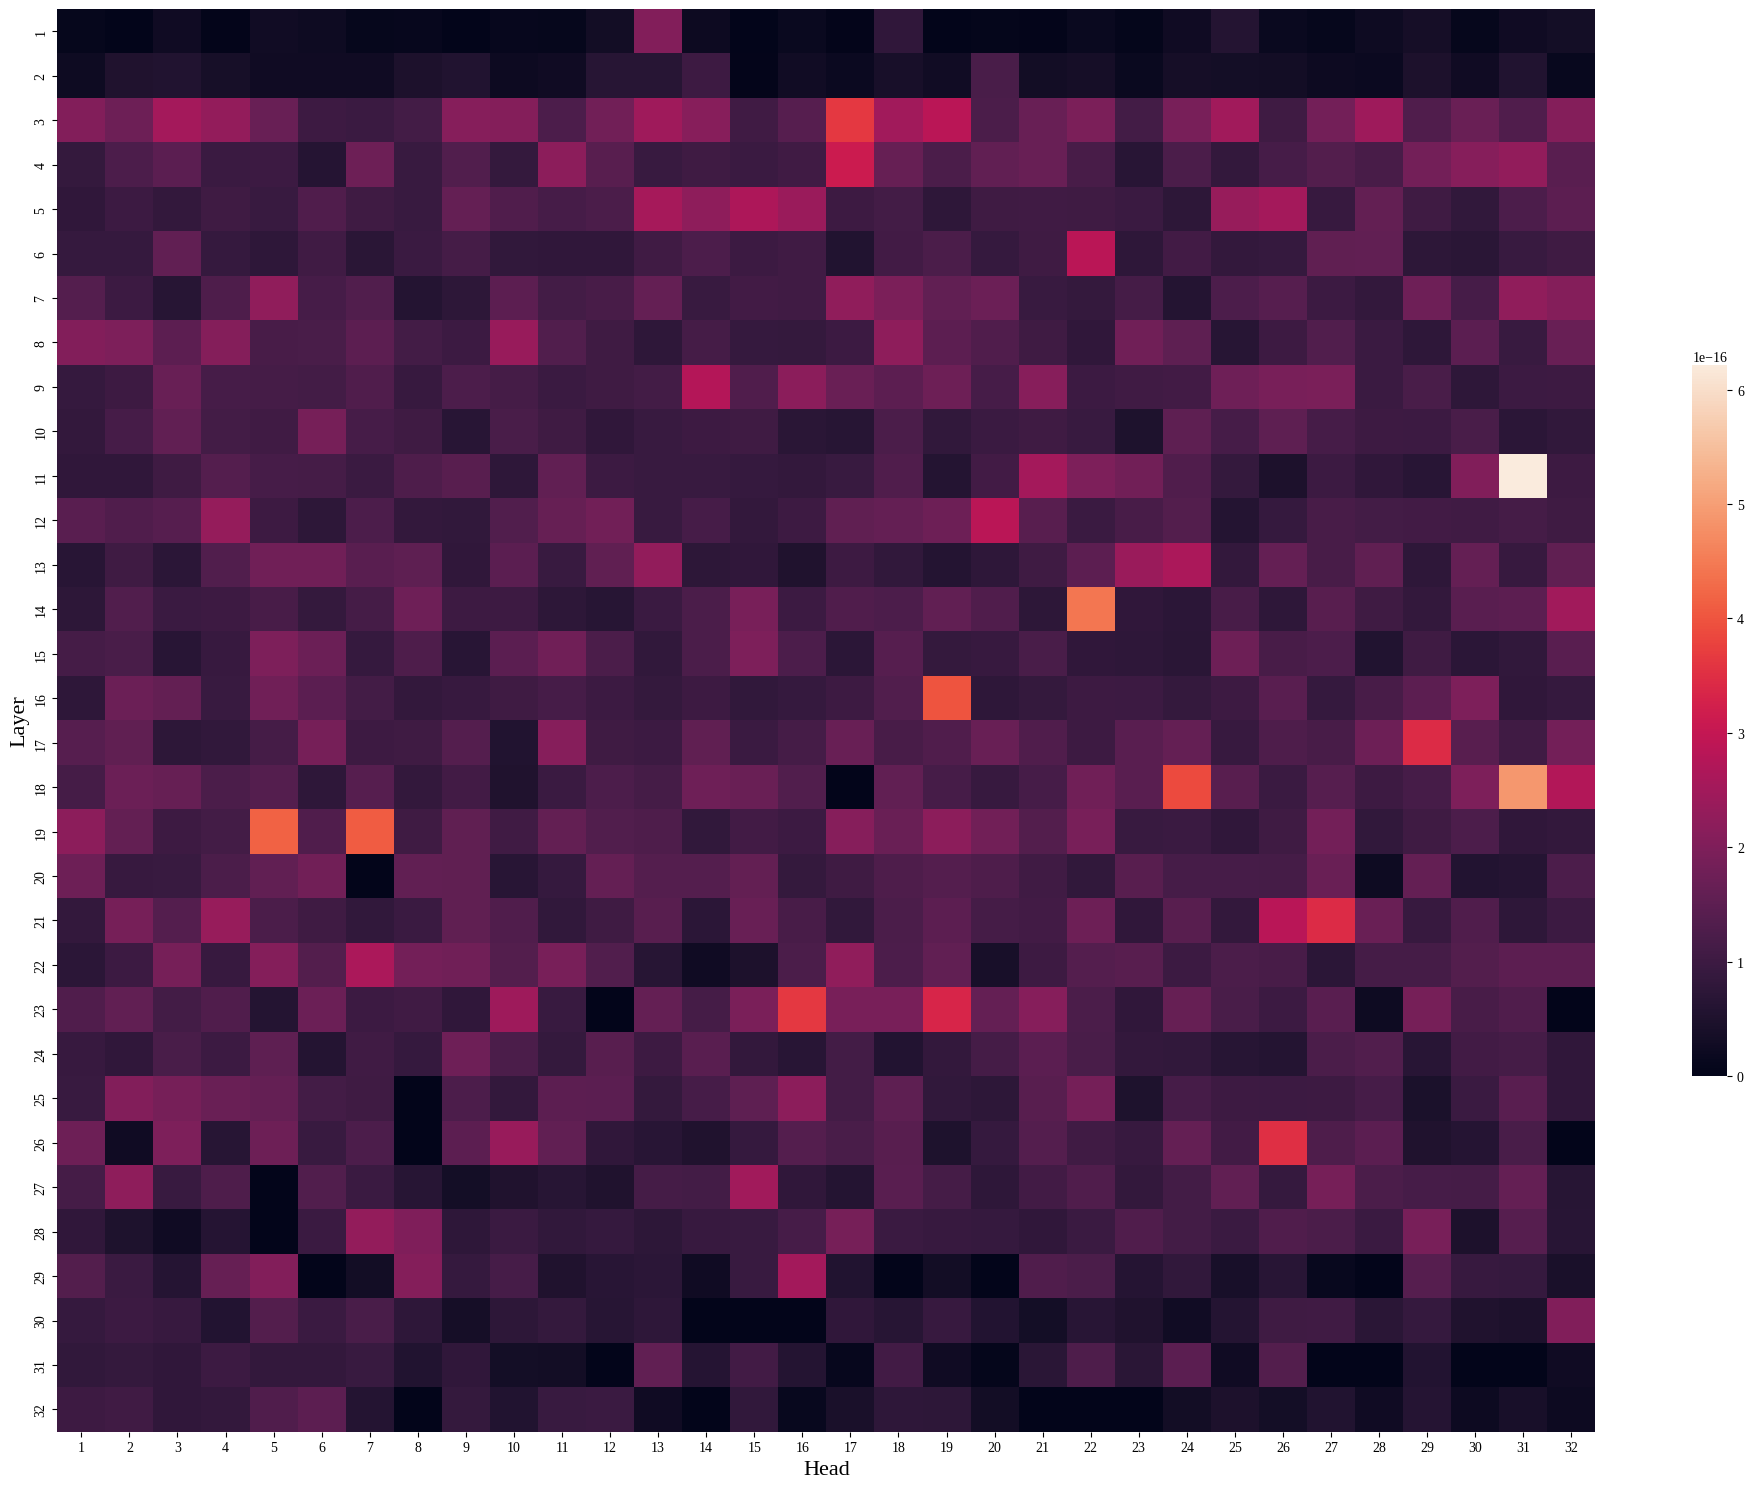


Computing ALR with L2 norm ranking and generating heatmap...

processing prompt: Stefan goes to a restaurant to eat dinner with his...

processing prompt: The gauge on a water tank shows that the tank is 1...

processing prompt: Ben has 8 apples more than Phillip does. Tom has t...

processing prompt: John wants to start a zoo.  He has 15 snakes.  He ...

processing prompt: A portable battery charger can fully charge a smar...

processing prompt: Darla needs to pay $4/watt of electricity for 300 ...

processing prompt: There have been 15 "Where's Waldo?" books publishe...

processing prompt: Bart makes a mixtape.  The first side has 6 songs....

processing prompt: An old pirate wants to leave his treasure on an is...

processing prompt: New York recorded 5000 new coronavirus cases on a ...

processing prompt: Brady will make $450 more in a year than Dwayne. I...

processing prompt: Carolyn is planning out her final essay. The intro...

processing prompt: Marie has 98 unread messages o

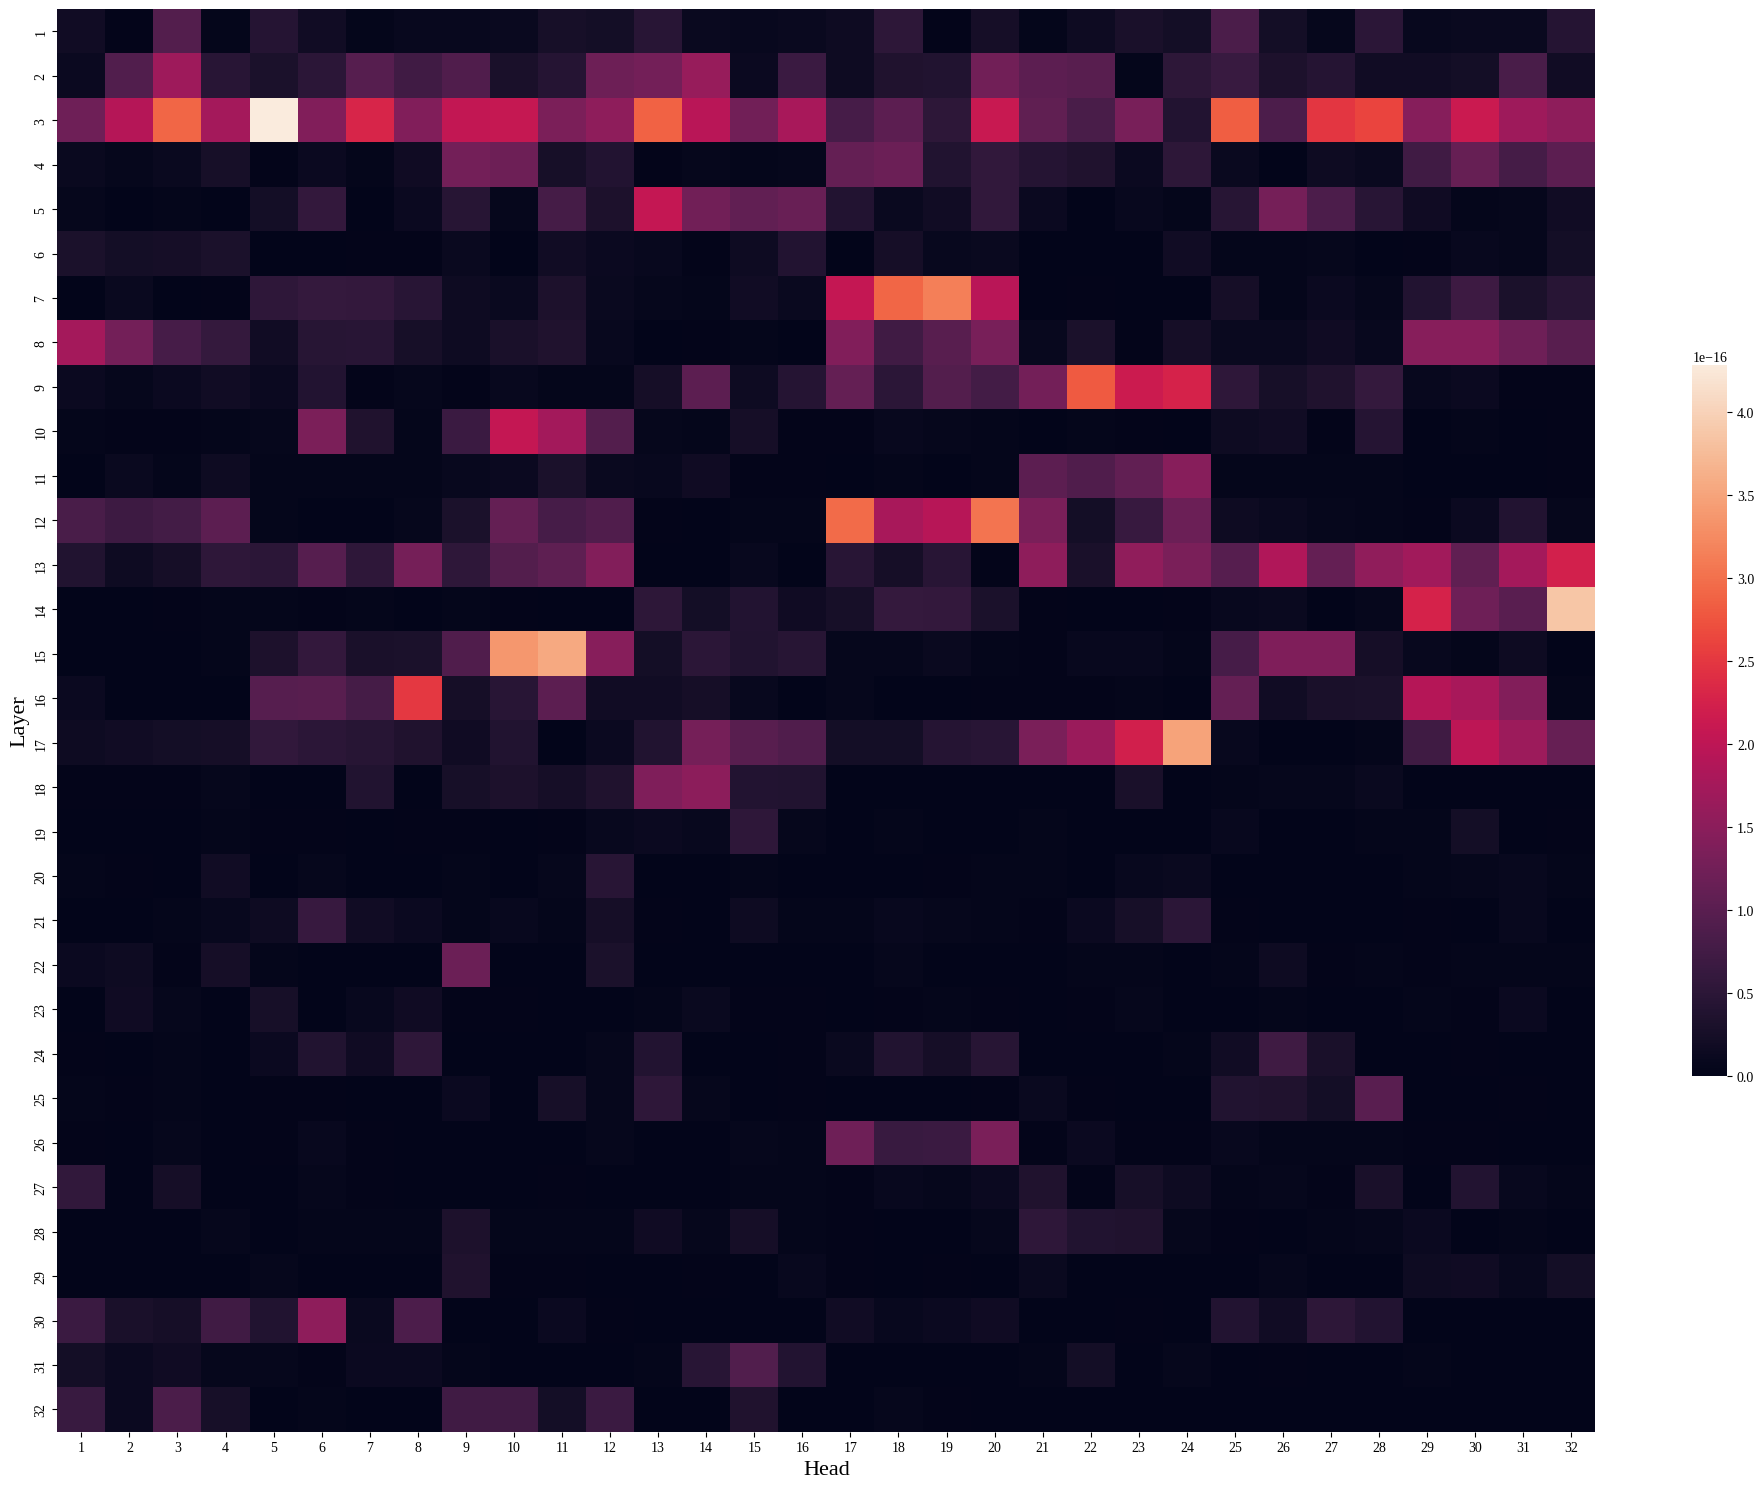

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from typing import List, Tuple
from datasets import load_dataset
import random
import math

# define rotate_half as it's used in apply_rotary_emb
def rotate_half(x):
    """
    rotates the last dimension halfway.

    args:
        x (torch.Tensor): input tensor

    returns:
        torch.Tensor: tensor after rotation
    """
    x1 = x[..., : x.size(-1) // 2]
    x2 = x[..., x.size(-1) // 2 :]
    return torch.cat((-x2, x1), dim=-1)

# main class - attention correlation analyzer
class AttentionCorrelationAnalyzer:
    def __init__(self, model_name: str, access_token: str = None, use_4bit: bool = False):
        """
        initialize the analyzer with a specified model.

        args:
            model_name (str): name of the model to load
            access_token (str, optional): hugging face access token for private models
            use_4bit (bool, optional): whether to use 4-bit quantization
        """
        # load the tokenizer for the specified model
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name,
            use_fast=True,
            token=access_token,
        )

        print("loading model...")
        if use_4bit:
            # configure 4-bit quantization settings
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.float16,
            )
            # load the model with 4-bit quantization
            try:
                self.model = AutoModelForCausalLM.from_pretrained(
                    model_name,
                    device_map="auto",
                    quantization_config=quantization_config,
                    torch_dtype=torch.float16,
                    low_cpu_mem_usage=True,
                    token=access_token,
                )
                print("model loaded with 4-bit quantization.")
            except Exception as e:
                print(f"error loading model with 4-bit quantization: {e}")
                print("attempting to load model without quantization.")
                self.model = AutoModelForCausalLM.from_pretrained(
                    model_name,
                    device_map="auto",
                    torch_dtype=torch.float16,
                    low_cpu_mem_usage=True,
                    token=access_token,
                )
                print("model loaded without quantization.")
                use_4bit = False  # update flag since quantization failed
        else:
            # load the model without quantization
            self.model = AutoModelForCausalLM.from_pretrained(
                model_name,
                device_map="auto",
                torch_dtype=torch.float16,
                low_cpu_mem_usage=True,
                token=access_token,
            )
            print("model loaded without quantization.")

        print("model loaded successfully.")
        # set the model to evaluation mode
        self.model.eval()
        # get the device where the model is loaded
        self.device = next(self.model.parameters()).device
        print(f"model device: {self.device}")

        # store model configuration parameters
        self.config = self.model.config
        self.num_layers = self.config.num_hidden_layers  # number of transformer layers
        self.num_heads = self.config.num_attention_heads  # total number of attention heads (query heads)
        self.hidden_size = self.config.hidden_size  # hidden size of the model
        self.head_dim = self.hidden_size // self.num_heads  # dimension per head

        # number of key/value heads (can be less than num_heads in gqa)
        self.num_key_value_heads = getattr(self.config, 'num_key_value_heads', self.num_heads)
        self.head_dim_kv = self.head_dim  # dimension per key/value head

        # number of times key/value heads are repeated to match query heads
        self.n_rep = self.num_heads // self.num_key_value_heads

        # prepare rope embeddings
        self._prepare_rope_cache()

        # list to store the captured data from hooks
        self.kv_captures = []

        # register hooks to capture key/value vectors and attention scores
        self._register_hooks()

    def _prepare_rope_cache(self):
        """
        prepare the rope embeddings cache.
        """
        inv_freq = 1.0 / (10000 ** (torch.arange(0, self.head_dim_kv, 2).float() / self.head_dim_kv))
        self.register_buffer = lambda name, tensor: setattr(self, name, tensor)

        # precompute sinusoidal embeddings
        max_position_embeddings = self.config.max_position_embeddings
        t = torch.arange(max_position_embeddings, device=self.device, dtype=torch.float32)
        freqs = torch.einsum("i,j->ij", t, inv_freq.to(self.device))
        emb = torch.polar(torch.ones_like(freqs), freqs)  # create complex numbers e^(i*freqs)
        self.register_buffer("rope_cache", emb)

    def reshape_for_broadcast(self, freqs_cis: torch.Tensor, x: torch.Tensor):
        """
        reshape the rope frequencies for broadcasting.

        args:
            freqs_cis (torch.Tensor): rope frequencies
            x (torch.Tensor): tensor to match the shape

        returns:
            torch.Tensor: reshaped frequencies
        """
        # x: [batch_size, num_heads, seq_len, head_dim // 2]
        # freqs_cis: [seq_len, head_dim // 2]
        ndim = x.ndim
        for _ in range(ndim - freqs_cis.ndim):
            freqs_cis = freqs_cis.unsqueeze(0)
        # now freqs_cis shape matches x for broadcasting
        return freqs_cis

    def apply_rotary_emb(
        self,
        xq: torch.Tensor,
        xk: torch.Tensor,
        seq_len: int,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        apply rotary position embeddings (rope) to the query and key tensors.

        args:
            xq (torch.Tensor): query tensor of shape [batch_size, num_heads, seq_len, head_dim]
            xk (torch.Tensor): key tensor of shape [batch_size, num_heads, seq_len, head_dim]
            seq_len (int): sequence length

        returns:
            tuple of torch.Tensor: tensors after applying rope
        """
        # reshape to (..., head_dim // 2, 2)
        xq_ = xq.float().reshape(*xq.shape[:-1], -1, 2)
        xk_ = xk.float().reshape(*xk.shape[:-1], -1, 2)

        # convert to complex numbers
        xq_ = torch.view_as_complex(xq_)
        xk_ = torch.view_as_complex(xk_)

        freqs_cis = self.rope_cache[:seq_len, :].to(xq_.device)
        freqs_cis = self.reshape_for_broadcast(freqs_cis, xq_)

        # apply rope
        xq_out = torch.view_as_real(xq_ * freqs_cis)
        xk_out = torch.view_as_real(xk_ * freqs_cis)

        # flatten back to original shape
        xq_out = xq_out.flatten(-2)
        xk_out = xk_out.flatten(-2)

        # cast back to original dtype
        xq_out = xq_out.type_as(xq)
        xk_out = xk_out.type_as(xk)

        return xq_out, xk_out

    def _register_hooks(self):
        """
        register forward hooks to capture key/value vectors and attention scores.
        """
        def create_hook(layer_idx):
            def hook(module, input, output):
                # extract hidden states from the input to the layer
                hidden_states = input[0]  # shape: [batch_size, seq_len, hidden_size]
                batch_size, seq_len, _ = hidden_states.size()

                # compute query, key, and value projections
                query_states = module.self_attn.q_proj(hidden_states)
                key_states = module.self_attn.k_proj(hidden_states)
                value_states = module.self_attn.v_proj(hidden_states)

                # reshape projections to separate heads
                query_states = query_states.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
                key_states = key_states.view(batch_size, seq_len, self.num_key_value_heads, self.head_dim_kv).transpose(1, 2)
                value_states = value_states.view(batch_size, seq_len, self.num_key_value_heads, self.head_dim_kv).transpose(1, 2)

                # apply rope to query and key projections
                query_states, key_states = self.apply_rotary_emb(query_states, key_states, seq_len)

                # repeat key and value states to match the number of query heads
                key_states = key_states.repeat_interleave(self.n_rep, dim=1)
                value_states = value_states.repeat_interleave(self.n_rep, dim=1)

                # scale query states by sqrt(head_dim)
                query_states = query_states / (self.head_dim ** 0.5)

                # compute attention scores
                attn_scores = torch.matmul(query_states, key_states.transpose(-1, -2))
                # apply softmax to get attention probabilities
                attn_probs = torch.nn.functional.softmax(attn_scores, dim=-1)

                # compute l2 norms of key and value vectors
                key_norms = torch.norm(key_states, dim=-1)
                value_norms = torch.norm(value_states, dim=-1)

                # store the captured data
                self.kv_captures.append({
                    'layer': layer_idx,
                    'attn_probs': attn_probs.detach().cpu(),
                    'query_states': query_states.detach().cpu(),
                    'key_norms': key_norms.detach().cpu(),
                    'key_states': key_states.detach().cpu(),  # capture key vectors
                    'value_norms': value_norms.detach().cpu(),
                })

            return hook

        # register the hook function for each transformer layer
        for idx, layer in enumerate(self.model.model.layers):
            layer.register_forward_hook(create_hook(idx))
            print(f"registered hook for layer {idx}.")

    def compute_lsh_bit_avg_rank(self, key_vectors: np.ndarray, query_vectors: np.ndarray, num_projections: int = 32, seed: int = 42) -> np.ndarray:
        """
        compute lsh bit average rankings for the given key vectors.

        args:
            key_vectors (np.ndarray): array of key vectors [num_keys, dim]
            query_vectors (np.ndarray): array of query vectors [num_queries, dim]
            num_projections (int, optional): number of random hyperplanes for lsh
            seed (int, optional): random seed for reproducibility

        returns:
            np.ndarray: array of hamming distances [num_queries]
        """
        np.random.seed(seed)  # set seed for reproducibility
        # generate random projection matrix
        random_proj = np.random.randn(key_vectors.shape[1], num_projections)
        # normalize the projection vectors
        random_proj /= np.linalg.norm(random_proj, axis=0)

        # compute hash bits
        hash_bits = np.dot(key_vectors, random_proj) > 0  # [num_keys, num_projections]
        query_bits = np.dot(query_vectors, random_proj) > 0  # [num_queries, num_projections]

        ham_dists = [0]
        for i in range(1, query_vectors.shape[0]):
            total_dist = 0
            for j in range(i + 1):
                total_dist += np.count_nonzero(query_bits[i] != hash_bits[j])
            ham_dists.append(total_dist / i)

        return np.asarray(ham_dists)

    def compute_alr(self, prompts: List[str], max_prompts: int = None, ranking_method: str = 'l2', num_projections: int = 32):
        """
        compute the attention loss ratio (alr) for the given prompts using specified ranking method.

        args:
            prompts (list of str): list of prompts to analyze
            max_prompts (int, optional): maximum number of prompts to process
            ranking_method (str, optional): 'l2' for l2 norms ranking, 'lsh' for lsh bit average ranking
            num_projections (int, optional): number of projections for lsh
        """
        assert ranking_method in ['l2', 'lsh'], "ranking_method must be 'l2' or 'lsh'"

        if max_prompts:
            prompts = prompts[:max_prompts]

        num_layers = self.num_layers
        num_heads = self.num_heads

        # initialize matrix to store alr values: [num_layers, num_heads]
        alr_matrix = np.zeros((num_layers, num_heads))

        for prompt in prompts:
            print(f"\nprocessing prompt: {prompt[:50]}...")

            # reset captures for each prompt
            self.kv_captures = []

            # tokenize the prompt
            inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)

            # perform a forward pass through the model
            with torch.no_grad():
                outputs = self.model(**inputs)

            seq_len = inputs.input_ids.size(1)

            # iterate over captured data from each layer
            for capture in self.kv_captures:
                layer_idx = capture['layer']
                attn_probs = capture['attn_probs'][0]  # shape: [num_heads, seq_len, seq_len]
                key_norms = capture['key_norms'][0]    # shape: [num_heads, seq_len]
                key_states = capture['key_states'][0]  # shape: [num_heads, seq_len, head_dim]
                query_states = capture['query_states'][0]  # shape: [num_heads, seq_len, head_dim]

                for head_idx in range(num_heads):
                    # attention probabilities for this head
                    attn_head = attn_probs[head_idx]  # shape: [seq_len, seq_len]
                    # mean attention scores over the sequence
                    mean_attn_scores = attn_head.mean(dim=0).numpy().astype(np.float64)  # shape: [seq_len]

                    # normalize mean_attn_scores to sum to 1
                    mean_attn_scores /= mean_attn_scores.sum()

                    if ranking_method == 'l2':
                        # use l2 norms for ranking
                        key_norm_head = key_norms[head_idx].numpy().astype(np.float64)  # shape: [seq_len]
                        indices_by_rank = np.argsort(-key_norm_head)  # indices of highest to lowest norms
                    elif ranking_method == 'lsh':
                        # use lsh bit average ranking
                        if 'key_states' not in capture:
                            continue
                        key_vectors = key_states[head_idx].numpy().astype(np.float64)  # shape: [seq_len, head_dim]
                        query_vectors = query_states[head_idx].numpy().astype(np.float64)  # shape: [seq_len, head_dim]
                        bit_avg = self.compute_lsh_bit_avg_rank(
                            key_vectors, query_vectors, num_projections=num_projections
                        )
                        indices_by_rank = np.argsort(-bit_avg)  # indices of highest to lowest bit_avg
                    else:
                        raise ValueError("invalid ranking_method. choose 'l2' or 'lsh'.")

                    # reference ranking (sorted by attention scores descending)
                    indices_by_attn = np.argsort(-mean_attn_scores)  # indices of highest to lowest attention scores

                    # compute attention losses for both rankings
                    # cumulative attention of kept tokens after dropping top m tokens
                    L_rank_cumsum = np.cumsum(mean_attn_scores[indices_by_rank[::-1]])
                    L_ref_cumsum = np.cumsum(mean_attn_scores[indices_by_attn[::-1]])

                    # compute attention loss by subtracting from total attention (which sums to 1)
                    attention_loss_rank = 1 - L_rank_cumsum
                    attention_loss_ref = 1 - L_ref_cumsum

                    # compute Y_m^{l,h} = L_m^{l,h} - L_m,ref^{l,h}
                    Y_m = attention_loss_rank - attention_loss_ref

                    # ensure Y_m is non-negative
                    Y_m = np.maximum(Y_m, 0)

                    # compute Y^{l,h} = sum over m of Y_m^{l,h}
                    Y_lh = np.sum(Y_m)

                    # store the alr value
                    alr_matrix[layer_idx, head_idx] += Y_lh  # sum over prompts

        # average alr over prompts
        alr_matrix /= len(prompts)

        # generate heatmap
        self._visualize_alr(alr_matrix, ranking_method, num_projections)

    def _visualize_alr(self, alr_matrix: np.ndarray, ranking_method: str, num_projections: int):
        """
        visualize the attention loss ratio (alr) as a heatmap.

        args:
            alr_matrix (numpy.ndarray): matrix of alr values [num_layers, num_heads]
            ranking_method (str): the ranking method used ('l2' or 'lsh') for title purposes
            num_projections (int): number of projections used in lsh
        """
        layers = np.arange(1, self.num_layers + 1)
        heads = np.arange(1, self.num_heads + 1)

        plt.figure(figsize=(20, 15))
        sns.heatmap(
            alr_matrix,
            cmap='rocket',
            xticklabels=heads,
            yticklabels=layers,
            annot=False,
            cbar_kws={'shrink': 0.5},
        )
        plt.xlabel('Head', fontsize=16)
        plt.ylabel('Layer', fontsize=16)
        # plt.title(f'ALR Heatmap using {ranking_method.upper()} Ranking\nProjection Length: {num_projections}', fontsize=20)
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    import torch
    from datasets import load_dataset

    model_name = "meta-llama/Meta-Llama-3-8B-Instruct"


    # clear cuda cache
    torch.cuda.empty_cache()

    # instantiate the analyzer
    analyzer = AttentionCorrelationAnalyzer(model_name, access_token=access_token, use_4bit=False)

    # load datasets
    gsm8k_ds = load_dataset("openai/gsm8k", "main")
    gsm8k_prompts = [x['question'] for x in gsm8k_ds['train']]

    # randomly select prompts
    random.seed(42)  # for reproducibility
    random.shuffle(gsm8k_prompts)
    max_prompts = 50  # adjust as needed
    selected_prompts = gsm8k_prompts[:max_prompts]

    # list of projection lengths to iterate over
    projection_lengths = [8, 16, 24, 32]

    for num_projections in projection_lengths:
        print(f"\nComputing ALR with LSH projection length {num_projections} and generating heatmap...")
        analyzer.compute_alr(selected_prompts, ranking_method='lsh', num_projections=num_projections)

    #compute ALR using L2 ranking for comparison
    print("\nComputing ALR with L2 norm ranking and generating heatmap...")
    analyzer.compute_alr(selected_prompts, ranking_method='l2')
